# Business problem we are trying to solve

This app predicts how much of a loan will be granted to an applicant. The app uses different information about the applicant profile and predict how much will be approved. Usually the applicant with a higher credit score, a co-applicant will be granted a larger loan amount. It depends also on how much the applicant has requested.


# 0. Import the necessary libraries

In [110]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
# from pandas_profiling import ProfileReport
from pathlib import Path
from sklearn.metrics import mean_squared_error
from scipy import stats
from yellowbrick.model_selection import FeatureImportances
import shap
import joblib
%matplotlib inline

# 1. Get the data

## 1.1 Import csv file

In [111]:
train_original = pd.read_csv('datasets/train.csv')
test_original = pd.read_csv('datasets/test.csv')

## 1.2 Split the data into training and test sets

In [112]:
train_original.shape

(30000, 24)

In [113]:
test_original.shape

(20000, 23)

In [114]:
train_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [115]:
test_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')

In [116]:
pd.set_option('display.max_columns', None)
train_original.head()

Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56      1933.050              Low   
1     C-33999  America Calderone      M   32      4952.910              Low   
2      C-3770      Rosetta Verne      F   65       988.190             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31      2614.770              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                  72809.580   
1    Working                    NaN  Semi-Urban                  46837.470   
2  Pensioner                    NaN  Semi-Urban                  45593.040   
3  Pensioner                    NaN       Rural                  80057.920   
4    Working  High skill tech staff  Semi-Urban                 113858.890   

   Current Loan Expenses (USD) Expense Type 1 Expense Type 2  Dependents  \
0                      241.080              N              N       3.000   
1                      495.810              N              Y       1.000   
2                      171.950              N              Y       1.000   
3                      298.540              N              Y       2.000   
4                      491.410              N              Y         NaN   

   Credit Score  No. of Defaults Has Active Credit Card  Property ID  \
0       809.440                0                    NaN          746   
1       780.400                0            Unpossessed          608   
2       833.150                0            Unpossessed          546   
3       832.700                1            Unpossessed          890   
4       745.550                1                 Active          715   

   Property Age  Property Type Property Location  Co-Applicant  \
0      1933.050              4             Rural             1   
1      4952.910              2             Rural             1   
2       988.190              2             Urban             0   
3           NaN              2        Semi-Urban             1   
4      2614.770              4        Semi-Urban             1   

   Property Price  Loan Sanction Amount (USD)  
0      119933.460                   54607.180  
1       54791.000                   37469.980  
2       72440.580                   36474.430  
3      121441.510                   56040.540  
4      208567.910                   74008.280

In [117]:
test_original.head()

Customer ID              Name Gender  Age  Income (USD) Income Stability  \
0     C-26247  Tandra Olszewski      F   47      3472.690              Low   
1     C-35067     Jeannette Cha      F   57      1184.840              Low   
2     C-34590      Keva Godfrey      F   52      1266.270              Low   
3     C-16668      Elva Sackett      M   65      1369.720             High   
4     C-12196    Sade Constable      F   60      1939.230             High   

             Profession Type of Employment    Location  \
0  Commercial associate           Managers  Semi-Urban   
1               Working        Sales staff       Rural   
2               Working                NaN  Semi-Urban   
3             Pensioner                NaN       Rural   
4             Pensioner                NaN       Urban   

   Loan Amount Request (USD)  Current Loan Expenses (USD) Expense Type 1  \
0                 137088.980                      396.720              N   
1                 104771.590                      463.760              Y   
2                 176684.910                      493.150              N   
3                  97009.180                      446.150              N   
4                 109980.000                      370.100              N   

  Expense Type 2  Dependents  Credit Score  No. of Defaults  \
0              N       2.000       799.140                0   
1              Y       2.000       833.310                0   
2              Y       3.000       627.440                0   
3              Y       2.000       833.200                0   
4              N         NaN           NaN                0   

  Has Active Credit Card  Property ID  Property Age  Property Type  \
0            Unpossessed          843      3472.690              2   
1            Unpossessed           22      1184.840              1   
2            Unpossessed            1      1266.270              1   
3               Inactive          730      1369.720              1   
4                    NaN          356      1939.230              4   

  Property Location Co-Applicant Property Price  
0             Urban            1       236644.5  
1             Rural            1       142357.3  
2             Urban            1      300991.24  
3        Semi-Urban            0       125612.1  
4        Semi-Urban            1       180908.0

Since the test dataset does not have the target variable (Loan Sanction Amount), we will split the train dataset into a new train and test dataset.

In [118]:
full_data = train_original

In [119]:
full_data.shape

(30000, 24)

In [120]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [121]:
loan_amt_train_original, loan_amt_test_original = data_split(full_data, 0.35)

In [122]:
loan_amt_train_copy, loan_amt_test_copy = loan_amt_train_original.copy(), loan_amt_test_original.copy()

In [123]:
loan_amt_train_copy.shape

(19500, 24)

In [124]:
loan_amt_test_copy.shape

(10500, 24)

# 2. Explore the data

## 2.1 Quick glance at the data

In [125]:
loan_amt_train_copy.head()

Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36900    Evelyne Zeitler      F   40      1434.670              Low   
1     C-13324      Marvella Egli      F   24           NaN              Low   
2     C-45055  Antonietta Dundon      M   26      1540.220              Low   
3      C-9142      Gertrud Krogh      F   37      1264.580              Low   
4     C-24998       Kenny Conine      F   23      1584.470              Low   

             Profession     Type of Employment    Location  \
0               Working               Laborers       Rural   
1               Working          Cooking staff       Rural   
2  Commercial associate         Cleaning staff  Semi-Urban   
3               Working            Sales staff  Semi-Urban   
4               Working  Private service staff  Semi-Urban   

   Loan Amount Request (USD)  Current Loan Expenses (USD) Expense Type 1  \
0                 182727.650                      773.930              N   
1                  29111.920                      150.030              N   
2                  86199.290                      416.670              N   
3                  74086.260                      415.550              Y   
4                  45274.480                      259.220              N   

  Expense Type 2  Dependents  Credit Score  No. of Defaults  \
0              N       3.000       720.490                0   
1              Y         NaN       651.490                0   
2              N       2.000       757.880                1   
3              Y       3.000       802.340                0   
4              Y       3.000       731.180                0   

  Has Active Credit Card  Property ID  Property Age  Property Type  \
0               Inactive          330      1434.670              1   
1            Unpossessed          307           NaN              1   
2               Inactive          125      1540.220              2   
3                 Active          435      1264.580              2   
4            Unpossessed          910      1584.470              4   

  Property Location  Co-Applicant  Property Price  Loan Sanction Amount (USD)  
0             Rural             1      243151.290                  118772.970  
1               NaN             1       54541.370                   18922.750  
2        Semi-Urban             1      144156.070                       0.000  
3             Rural             1      138527.790                   59269.010  
4        Semi-Urban             1       66852.760                   31692.140

In [126]:
loan_amt_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19500 entries, 0 to 19499
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  19500 non-null  object 
 1   Name                         19500 non-null  object 
 2   Gender                       19461 non-null  object 
 3   Age                          19500 non-null  int64  
 4   Income (USD)                 16526 non-null  float64
 5   Income Stability             18468 non-null  object 
 6   Profession                   19500 non-null  object 
 7   Type of Employment           14761 non-null  object 
 8   Location                     19500 non-null  object 
 9   Loan Amount Request (USD)    19500 non-null  float64
 10  Current Loan Expenses (USD)  19396 non-null  float64
 11  Expense Type 1               19500 non-null  object 
 12  Expense Type 2               19500 non-null  object 
 13  Dependents      

In [127]:
loan_amt_train_copy.describe()

Age  Income (USD)  Loan Amount Request (USD)  \
count 19500.000     16526.000                  19500.000   
mean     40.087      2551.856                  88985.919   
std      16.086      1745.404                  59796.985   
min      18.000       378.760                   6108.050   
25%      25.000      1649.420                  41228.270   
50%      40.000      2217.385                  75166.980   
75%      55.000      3090.477                 120121.193   
max      65.000    122966.280                 621497.820   

       Current Loan Expenses (USD)  Dependents  Credit Score  No. of Defaults  \
count                    19396.000   17885.000     18387.000        19500.000   
mean                       400.122       2.253       739.578            0.193   
std                        241.713       0.950        72.369            0.395   
min                       -999.000       1.000       580.000            0.000   
25%                        248.167       2.000       680.665            0.000   
50%                        374.795       2.000       739.650            0.000   
75%                        520.963       3.000       799.215            0.000   
max                       3025.400      10.000       896.260            1.000   

       Property ID  Property Age  Property Type  Co-Applicant  Property Price  \
count    19500.000     16366.000      19500.000     19500.000       19500.000   
mean       501.856      2552.644          2.470        -4.274      131933.258   
std        288.383      1746.980          1.120        71.420       93678.679   
min          1.000       378.760          1.000      -999.000        -999.000   
25%        251.000      1650.345          1.000         1.000       60658.740   
50%        502.000      2221.010          2.000         1.000      110305.925   
75%        751.000      3091.620          3.000         1.000      178974.645   
max        999.000    122966.280          4.000         1.000     1077966.730   

       Loan Sanction Amount (USD)  
count                   19268.000  
mean                    47577.797  
std                     48296.582  
min                      -999.000  
25%                         0.000  
50%                     35013.020  
75%                     74079.872  
max                    395368.740

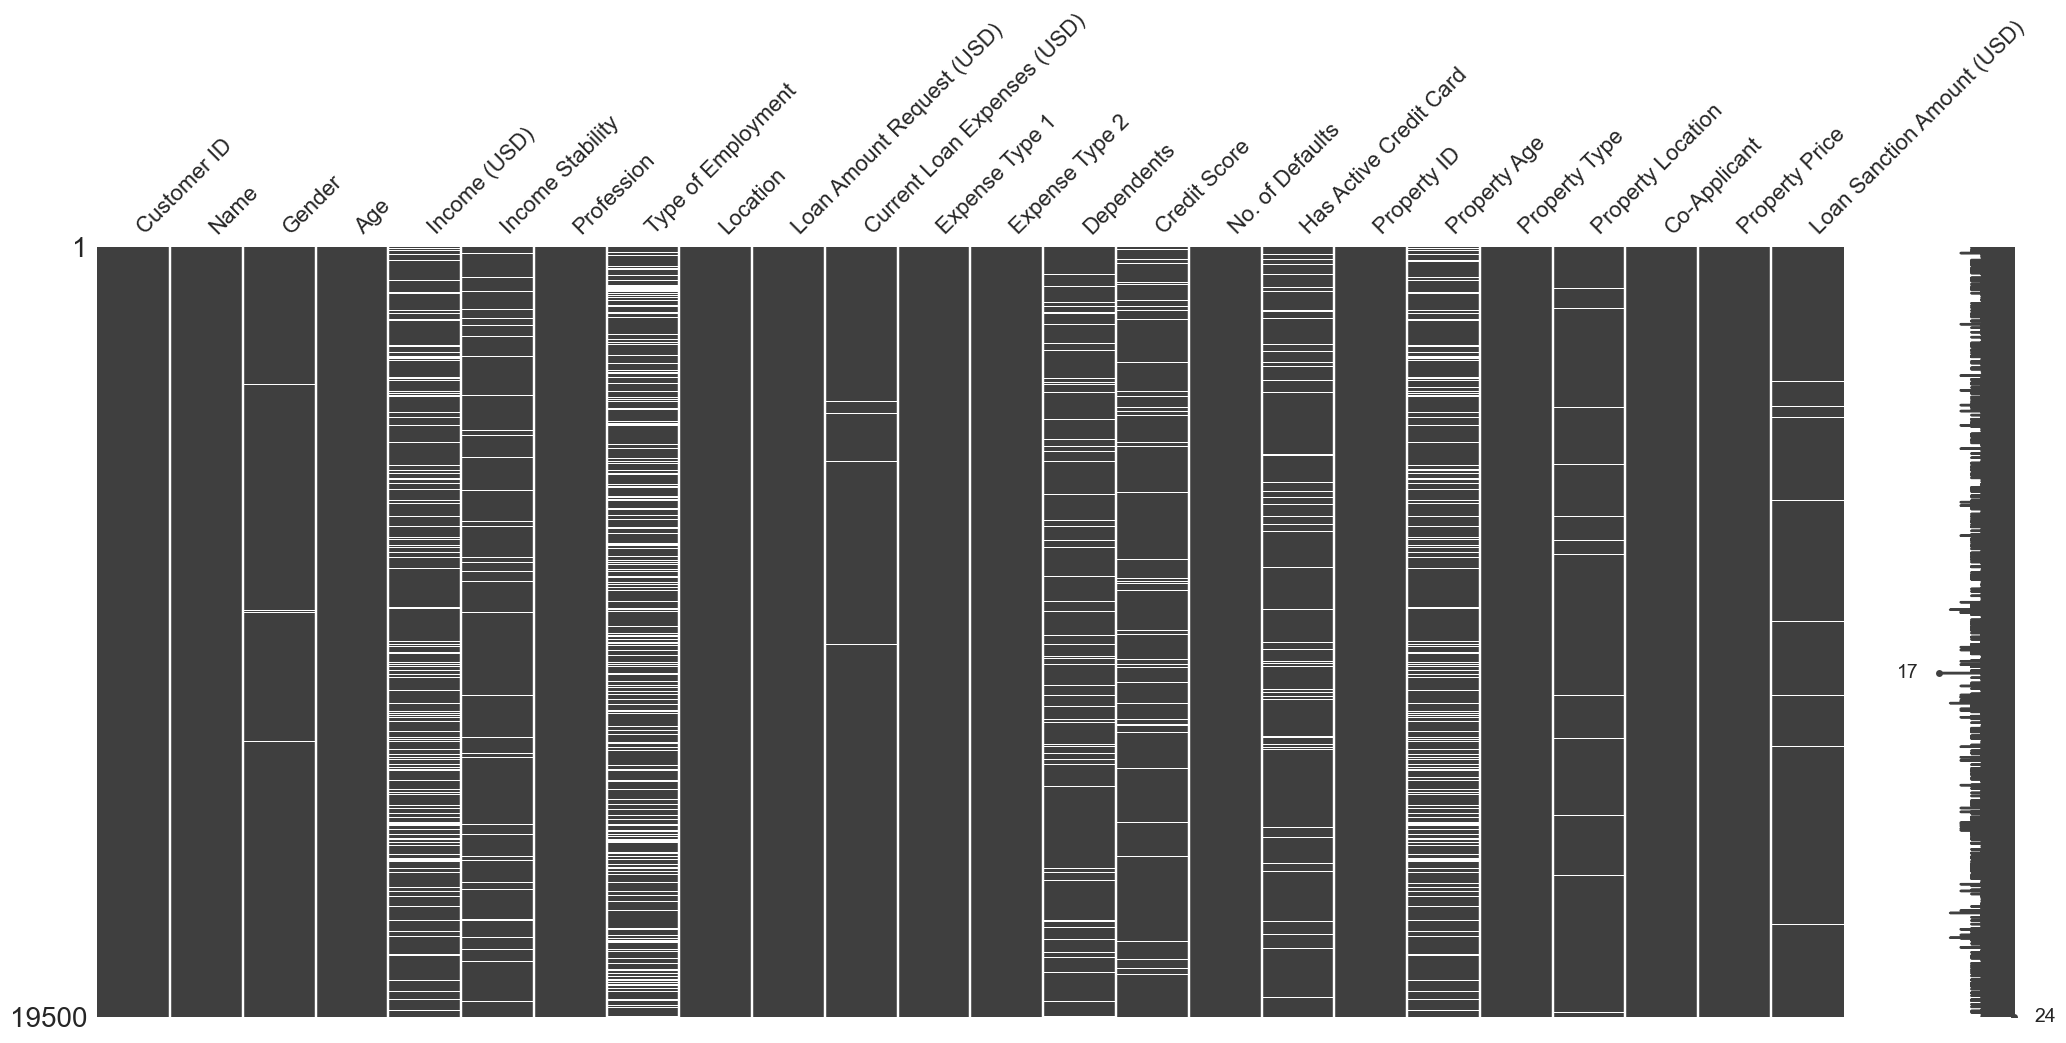

In [128]:
msno.matrix(loan_amt_train_copy)
plt.show()

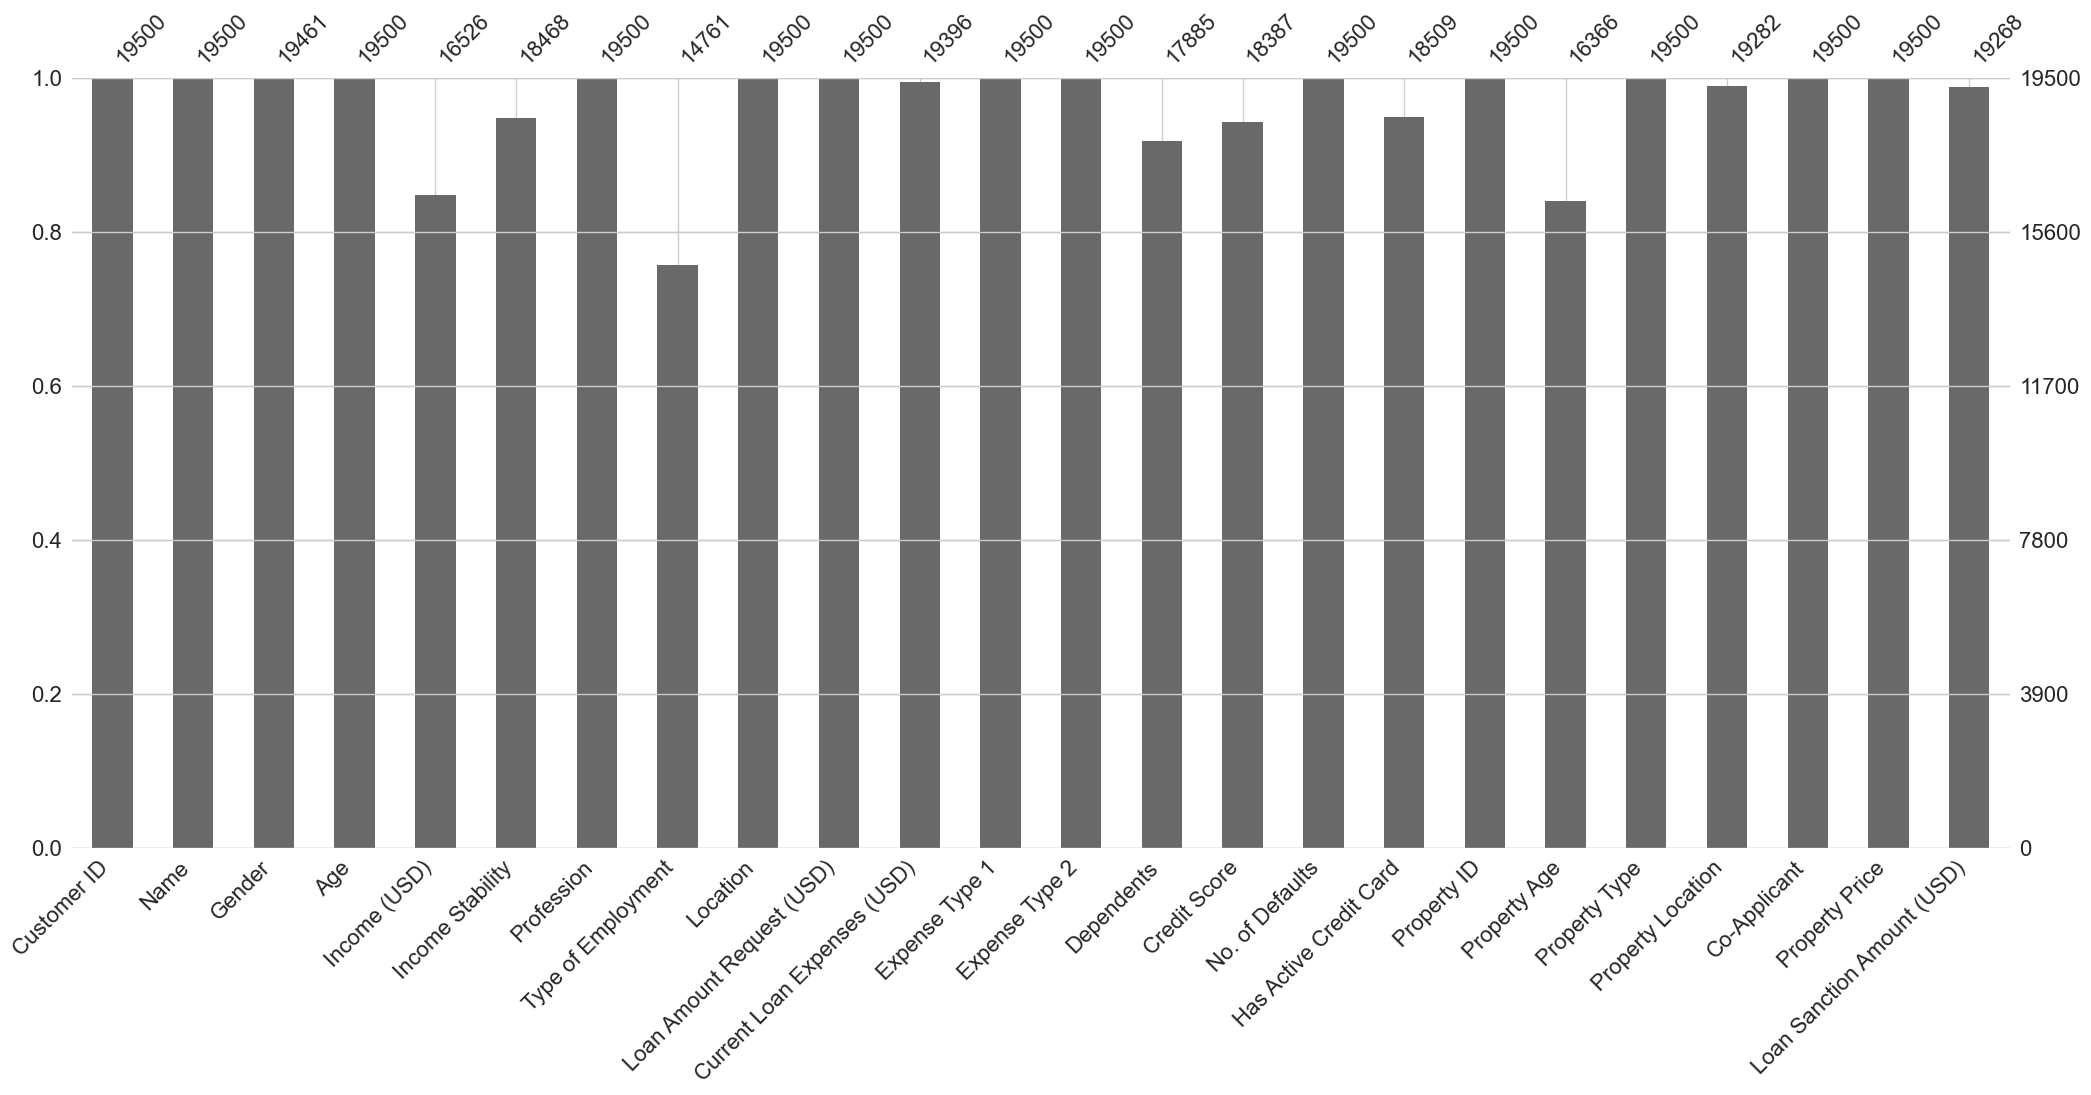

In [129]:
msno.bar(loan_amt_train_copy)
plt.show()

## 2.2 Functions used in the EDA of each feature

In [130]:
def value_cnt_norm_cal(df,feature):
    '''
    Function that will return the value count and frequency of each observation within a feature
    '''
    ftr_value_cnt = df[feature].value_counts()
    # normalize the value count
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [131]:
def gen_info_feat(df,feature):
    '''
    function to create display general information about the feature
    '''
    match feature:
        case 'Age' | 'Income (USD)' | 'Loan Amount Request (USD)' | 'Current Loan Expenses (USD)' | 'Credit Score' | 'Property Price' | 'Loan Sanction Amount (USD)':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Skewness:\n{}'.format(df[feature].skew()))
        case 'Property Age':
            print('Description:\n{}'.format(df[feature].describe()/365.25))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Skewness:\n{}'.format(df[feature].skew()))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [132]:
def create_bar_plot(df,feature):
    '''
    function to create a bar chart plot
    '''
    match feature:
        case 'Profession' | 'Type of Employment' | 'Dependents':
            fig, ax = plt.subplots(figsize=(8,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0], color='dimgray')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.xticks(rotation=45,ha='right')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.xticks(rotation=45,ha='right')
            plt.title('{} count'.format(feature))
            return plt.show()

In [133]:
def create_donnut_pie_chart(df,feature):
    '''
    function to create a donnut pie chart
    '''
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(8,8))
    # %1.2f%% display decimals in the pie chart with 2 decimal places
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
    plt.title('Pie chart of {}'.format(feature))
    plt.legend(loc='best')
    plt.axis('equal')
    # add a circle at the center to transform it in a donut chart
    circle=plt.Circle( (0,0), 0.8, color='white')
    p=plt.gcf()
    p.gca().add_artist(circle)
    return plt.show()

In [134]:
def create_box_plot(df,feature):
    '''
    function to create a box plot
    '''
    match feature:
        case 'Property Age':
            fig, ax = plt.subplots(figsize=(2, 8))
            sns.boxplot(y=df[feature]/365.25)
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

In [135]:
def create_hist_plot(df,feature, the_bins=50):
    '''
    function to create a histogram plot
    '''
    match feature:
        case 'Property Age':
            fig, ax = plt.subplots(figsize=(18, 10))
            sns.histplot(df[feature]/365.25, bins=the_bins, kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [136]:
def missing_val_norm(df,feature):
    feat_nan_count = df[feature].isnull().sum()
    rows_count = df.shape[0]
    return 'The percentage of missing rows is {:.2f} %'.format(feat_nan_count * 100 / rows_count)

## 2.3. Univariate analysis

### 2.3.1 Gender

In [137]:
gen_info_feat(loan_amt_train_copy,'Gender')

Description:
count     19461
unique        2
top           M
freq       9815
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
M   9815         50.434
F   9646         49.566


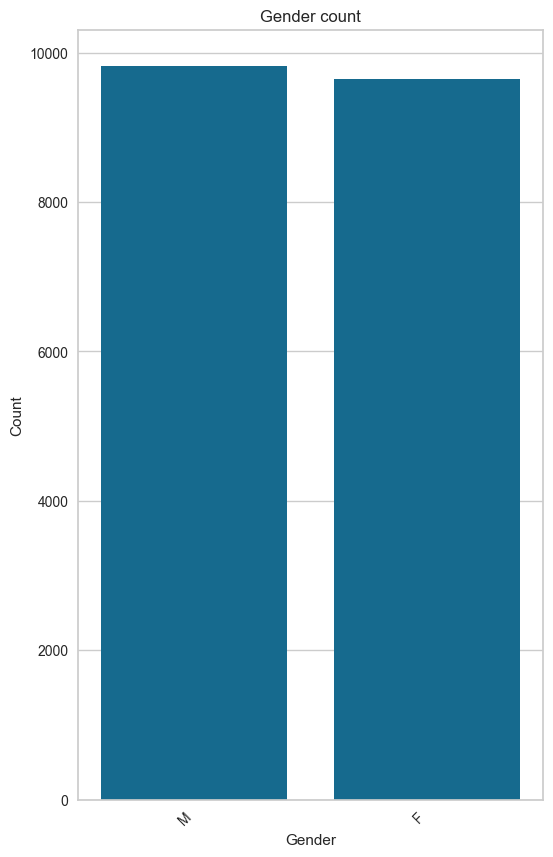

In [138]:
create_bar_plot(loan_amt_train_copy,'Gender')

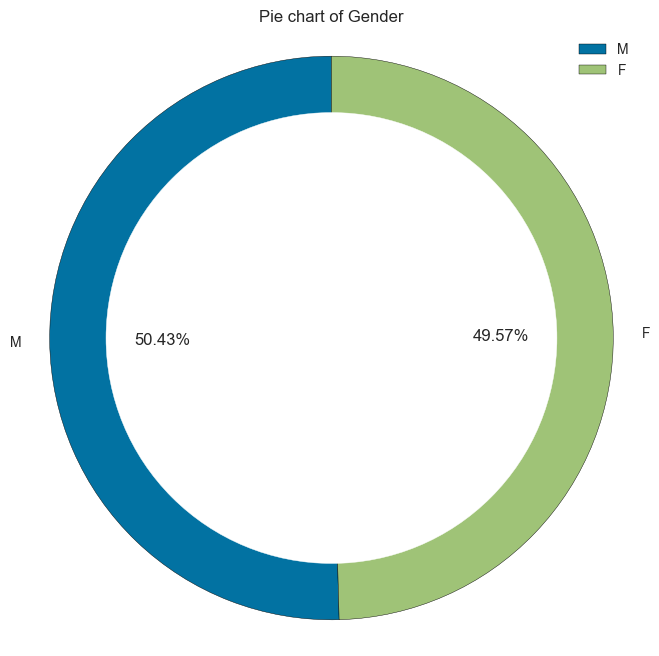

In [139]:
create_donnut_pie_chart(loan_amt_train_copy,'Gender')

Interpretation:
- We have almost the same number of Male vs Female (50.46% vs 49.54%)

### 2.3.2 Age

In [140]:
gen_info_feat(loan_amt_train_copy, 'Age')

Description:
count   19500.000
mean       40.087
std        16.086
min        18.000
25%        25.000
50%        40.000
75%        55.000
max        65.000
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Skewness:
0.04736566619271935


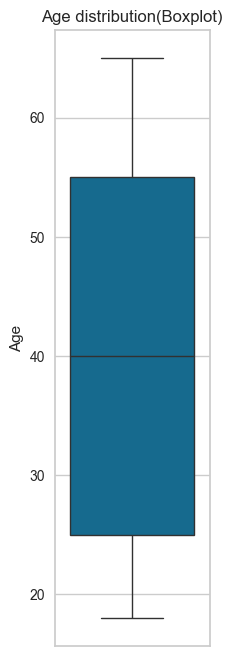

In [141]:
create_box_plot(loan_amt_train_copy, 'Age')

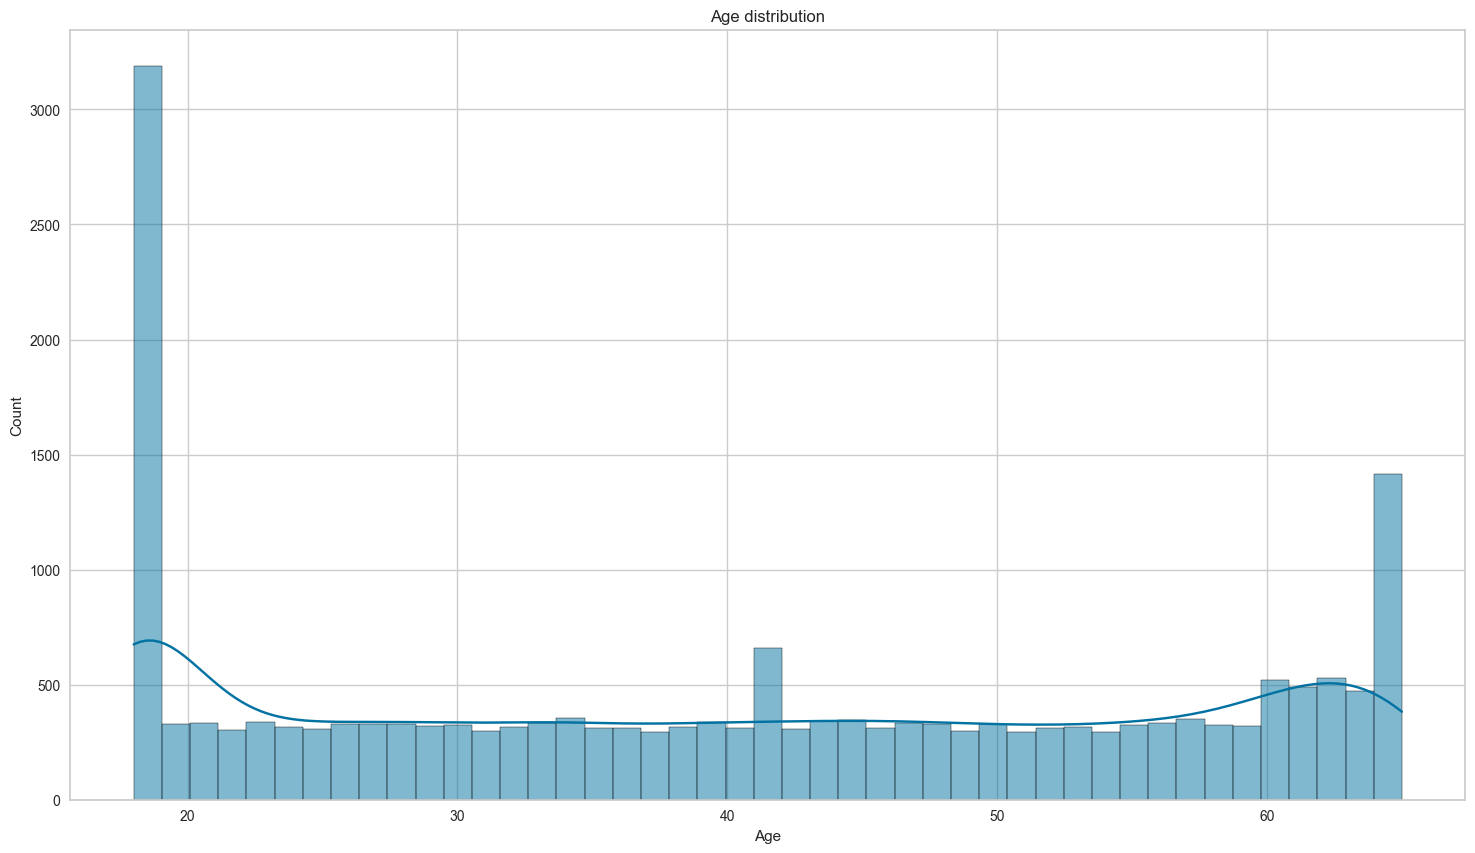

In [142]:
create_hist_plot(loan_amt_train_copy, 'Age', the_bins=45)

Interpretation:
- Age is not normally distributed
- We have a large number of applicants who are 18 and 65 years old
- Mean and median of age is 40 years old

### 2.3.3 Income

In [143]:
gen_info_feat(loan_amt_train_copy, 'Income (USD)')

Description:
count    16526.000
mean      2551.856
std       1745.404
min        378.760
25%       1649.420
50%       2217.385
75%       3090.477
max     122966.280
Name: Income (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
22.371505129608664


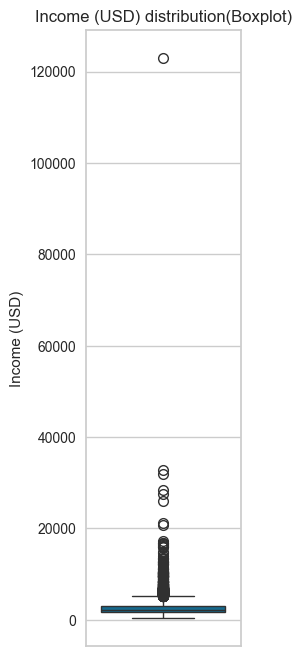

In [144]:
create_box_plot(loan_amt_train_copy, 'Income (USD)')

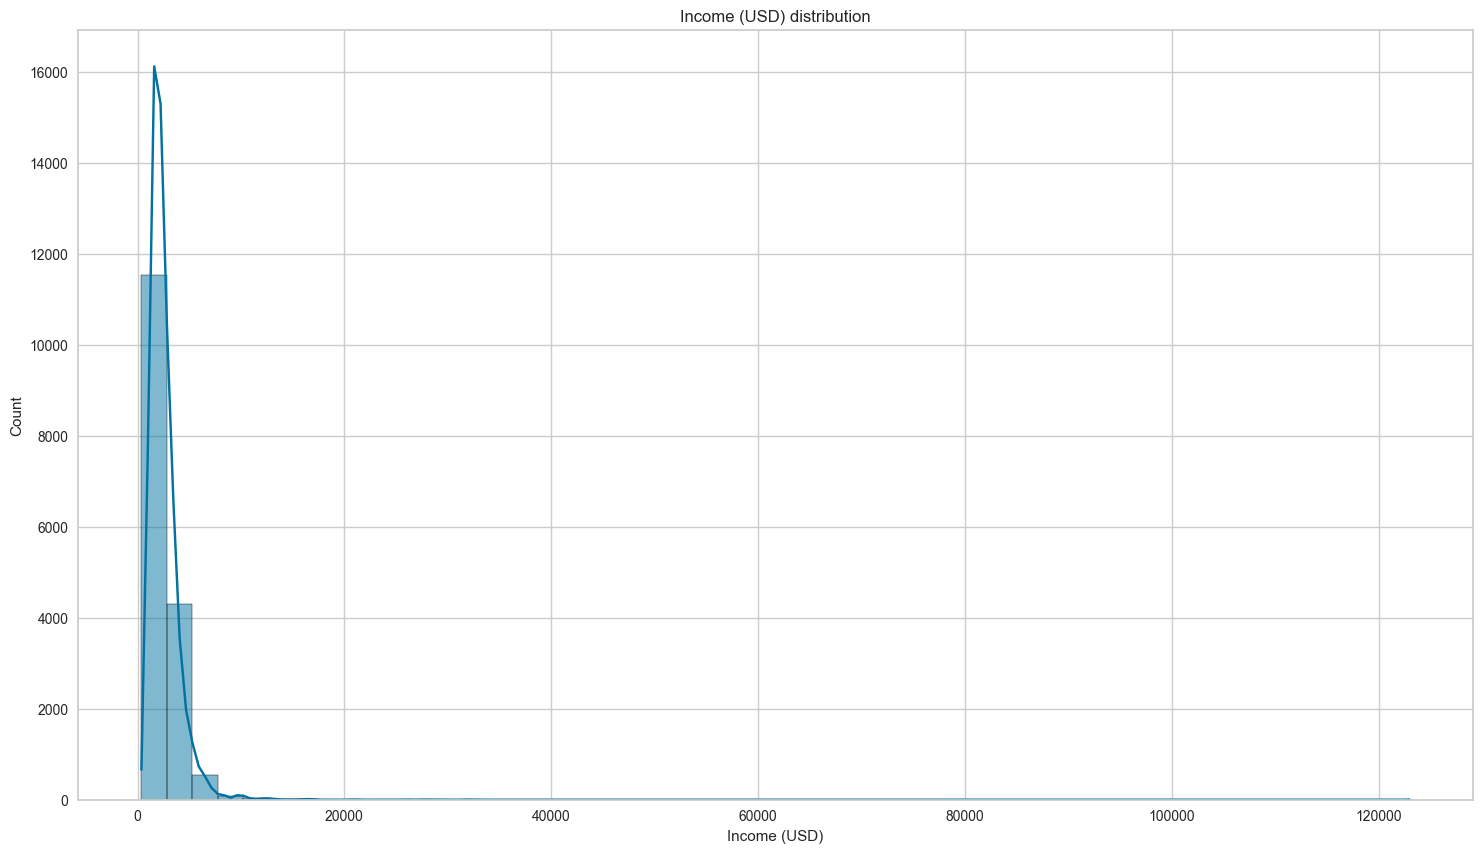

In [145]:
create_hist_plot(loan_amt_train_copy, 'Income (USD)', the_bins=50)

In [146]:
missing_val_norm(loan_amt_train_copy, 'Income (USD)')

'The percentage of missing rows is 15.25 %'

Interpretation:
- The Income feature has 15% of its data missing.
- The Income is positively skewed.
- The Income has a lot of outliers.
- The median income is $2229.

### 2.3.4 Income stability

In [147]:
gen_info_feat(loan_amt_train_copy,'Income Stability')

Description:
count     18468
unique        2
top         Low
freq      16763
Name: Income Stability, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
      Count  Frequency (%)
Low   16763         90.768
High   1705          9.232


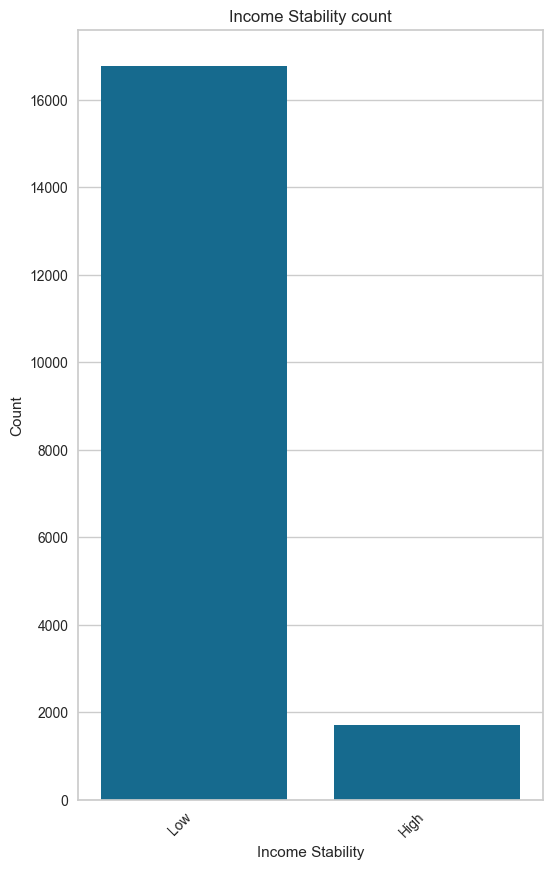

In [148]:
create_bar_plot(loan_amt_train_copy,'Income Stability')

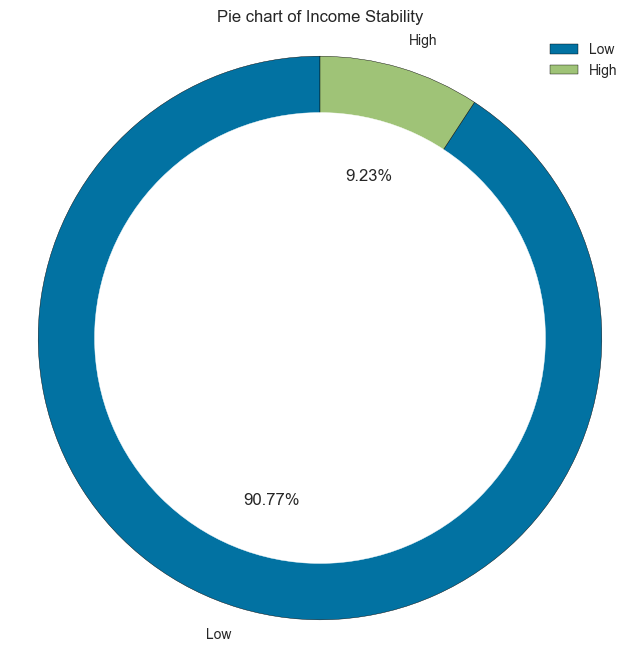

In [149]:
create_donnut_pie_chart(loan_amt_train_copy,'Income Stability')

Interpretation:
- Less than 10% of applicants have a high income stability
- 90% of applicants have a low income stability

### 2.3.5 Profession

In [150]:
gen_info_feat(loan_amt_train_copy,'Profession')

Description:
count       19500
unique          6
top       Working
freq        10939
Name: Profession, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Working               10939         56.097
Commercial associate   5225         26.795
Pensioner              1806          9.262
State servant          1527          7.831
Unemployed                2          0.010
Student                   1          0.005


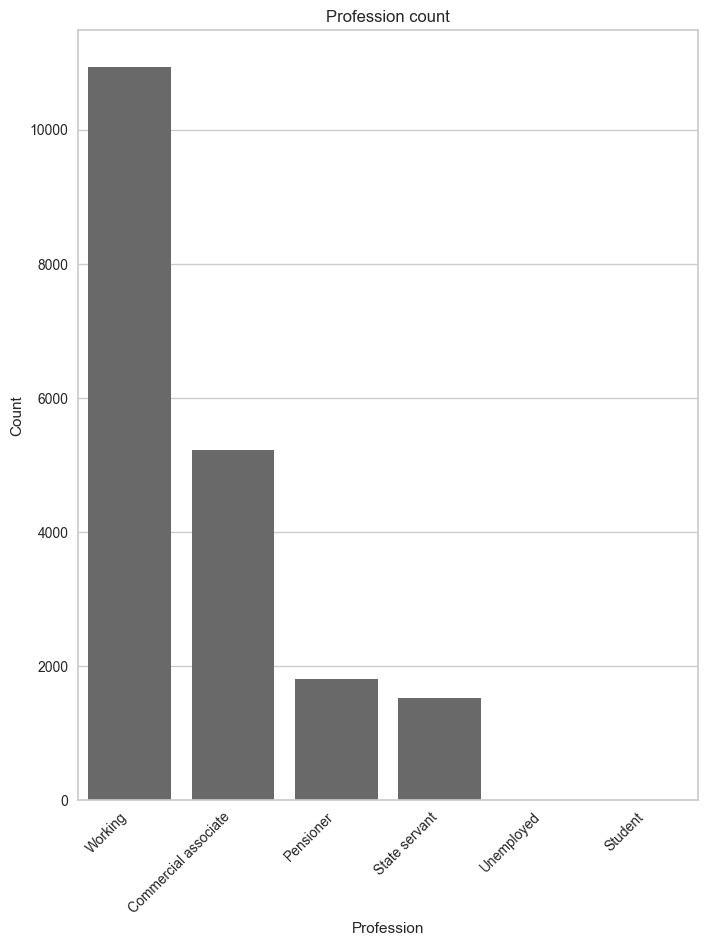

In [151]:
create_bar_plot(loan_amt_train_copy,'Profession')

Interpretation:
- Most applicants are currently working, the second most represented category is commercial associate.
- We also have a number of applicants that have pensioned and state servant.
- The most unrepresented category are the unemployed, businessman and student.

### 2.3.6 Type of employment

In [152]:
gen_info_feat(loan_amt_train_copy,'Type of Employment')

Description:
count        14761
unique          18
top       Laborers
freq          3655
Name: Type of Employment, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Laborers                3655         24.761
Sales staff             2407         16.306
Core staff              2089         14.152
Managers                1621         10.982
Drivers                 1036          7.018
Accountants              886          6.002
High skill tech staff    843          5.711
Medicine staff           540          3.658
Security staff           384          2.601
Cooking staff            373          2.527
Cleaning staff           237          1.606
Private service staff    233          1.578
Secretaries              107          0.725
Waiters/barmen staff     101          0.684
Low-skill Laborers       101          0.684
Realty agents             55    

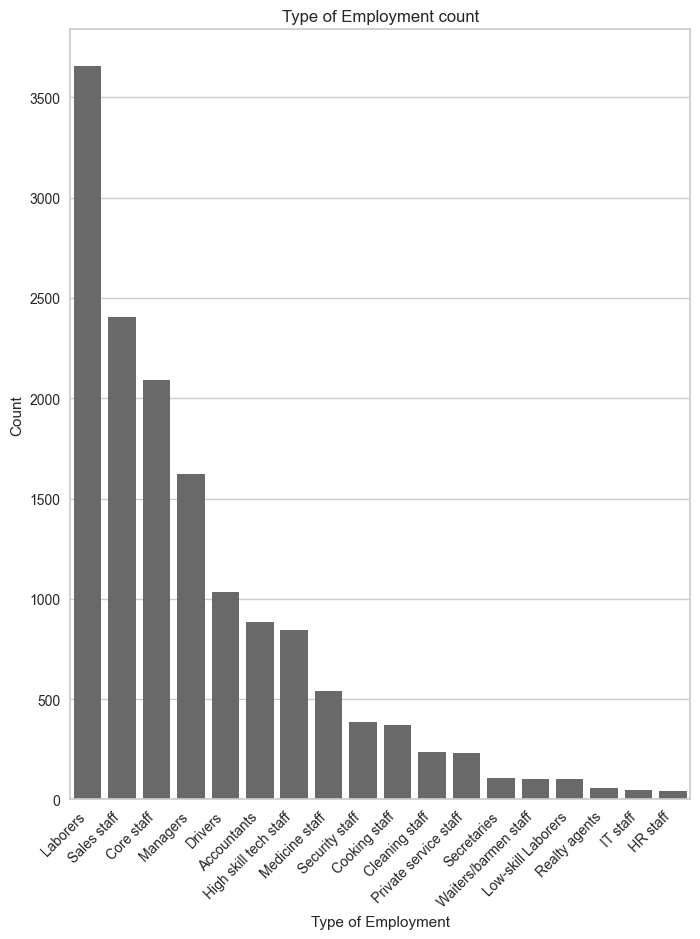

In [153]:
create_bar_plot(loan_amt_train_copy,'Type of Employment')

Interpretation:
- The most represented employment are laborers, sales staff, core staff and managers.
- The least represented employment are secretaries, low-skill laborers, waiters/barmen staff, realty agents, IT staff, HR staff.

### 2.3.7 Location

In [154]:
gen_info_feat(loan_amt_train_copy,'Location')

Description:
count          19500
unique             3
top       Semi-Urban
freq           13959
Name: Location, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency (%)
Semi-Urban  13959         71.585
Rural        3502         17.959
Urban        2039         10.456


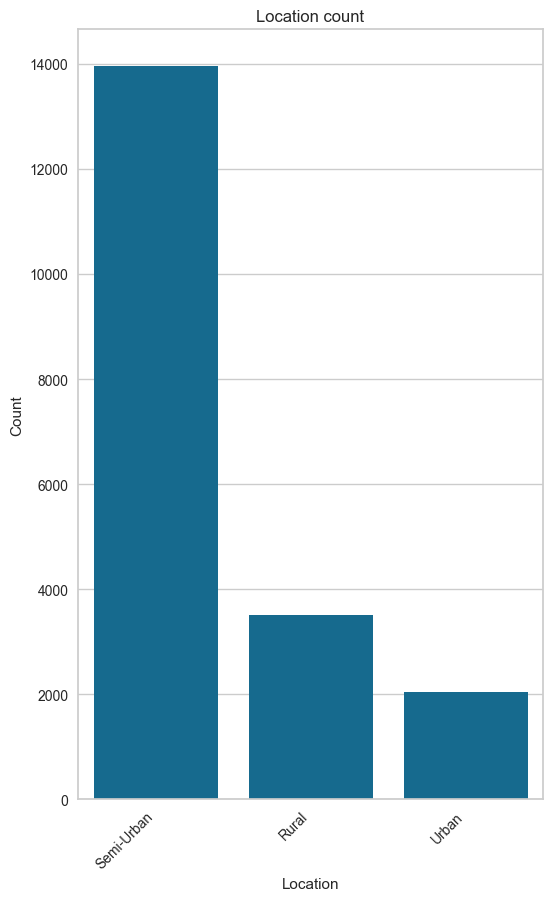

In [155]:
create_bar_plot(loan_amt_train_copy,'Location')

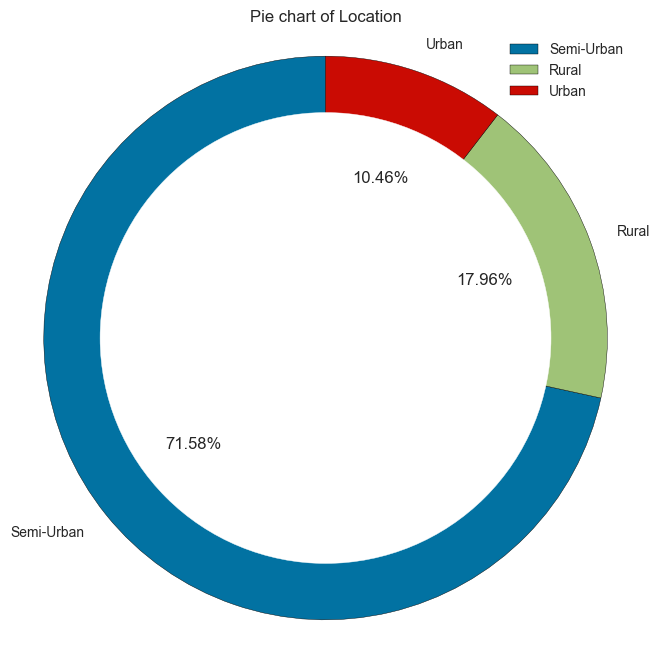

In [156]:
create_donnut_pie_chart(loan_amt_train_copy,'Location')

Interpretation:
- 7 out 10 applicants live in a semi-urban location
- Second most common location is the rural location
- Only 1 in 10 applicant live in an urban location

### 2.3.8 Loan Amount Request

In [157]:
gen_info_feat(loan_amt_train_copy,'Loan Amount Request (USD)')

Description:
count    19500.000
mean     88985.919
std      59796.985
min       6108.050
25%      41228.270
50%      75166.980
75%     120121.193
max     621497.820
Name: Loan Amount Request (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.2678312834844263


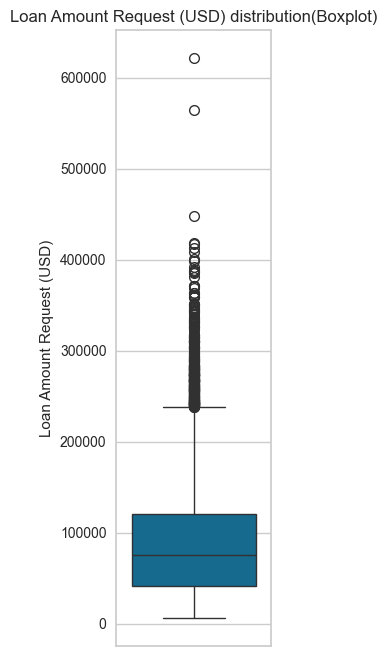

In [158]:
create_box_plot(loan_amt_train_copy, 'Loan Amount Request (USD)')

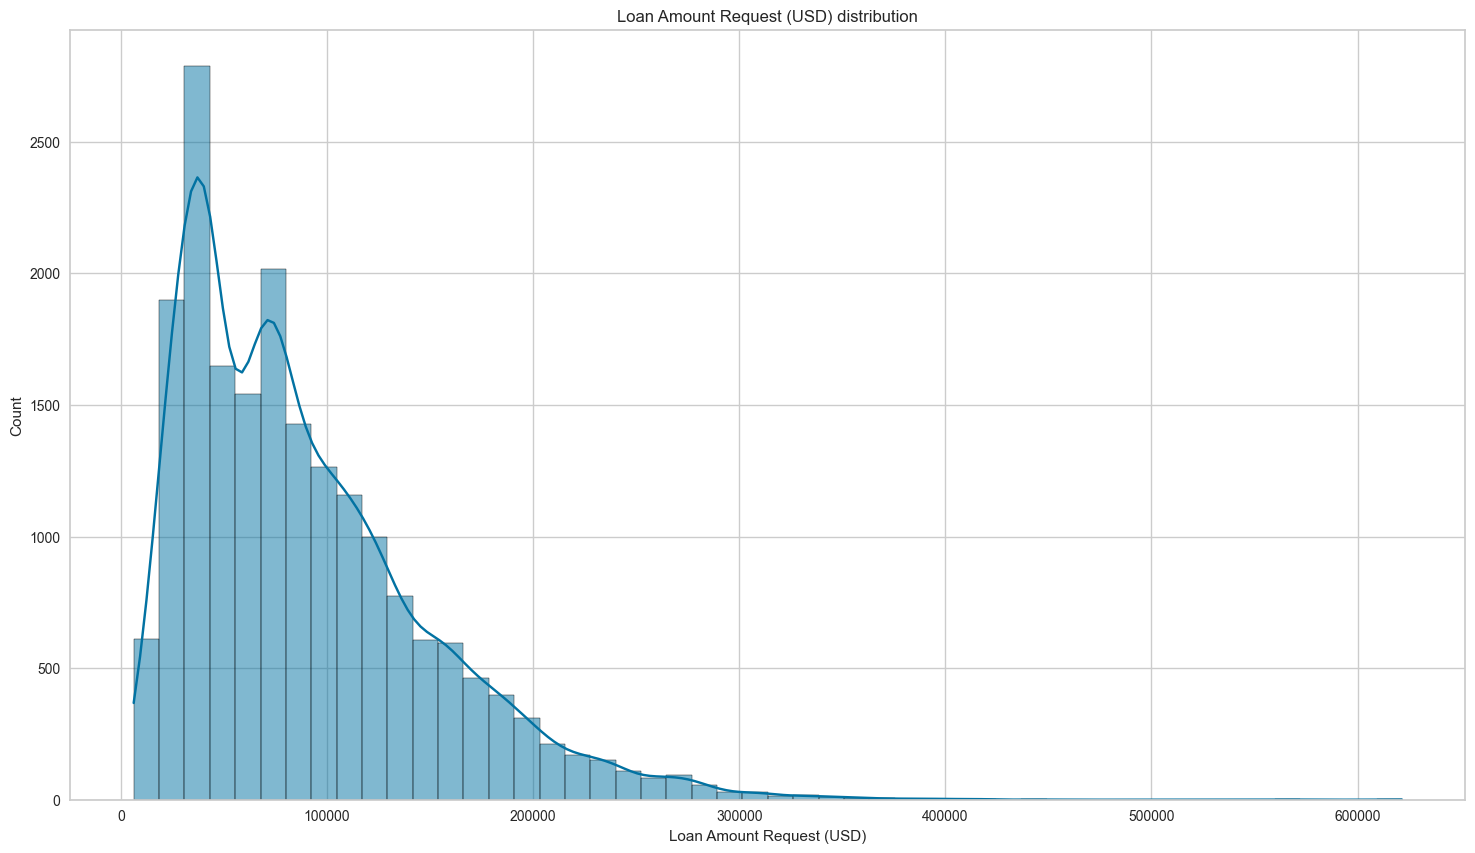

In [159]:
create_hist_plot(loan_amt_train_copy, 'Loan Amount Request (USD)')

Interpretation:
- The median of the loan amount request is $75326.655000
- We have quite a number of outliers in the loan amount request.
- The loan amount request distribution is positively skewed.

### 2.3.9 Current Loan Expenses

In [160]:
gen_info_feat(loan_amt_train_copy,'Current Loan Expenses (USD)')

Description:
count   19396.000
mean      400.122
std       241.713
min      -999.000
25%       248.167
50%       374.795
75%       520.963
max      3025.400
Name: Current Loan Expenses (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
-0.19973882449384497


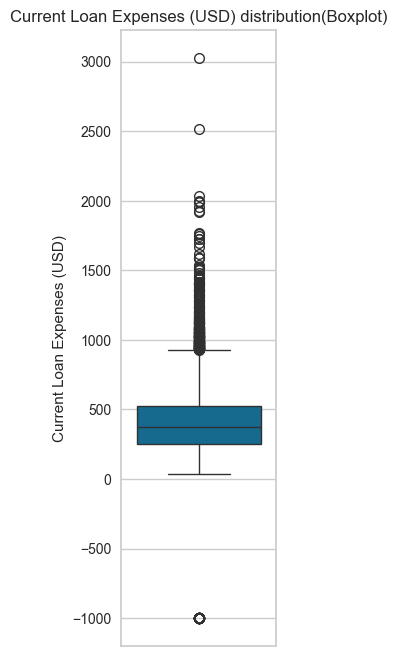

In [161]:
create_box_plot(loan_amt_train_copy, 'Current Loan Expenses (USD)')

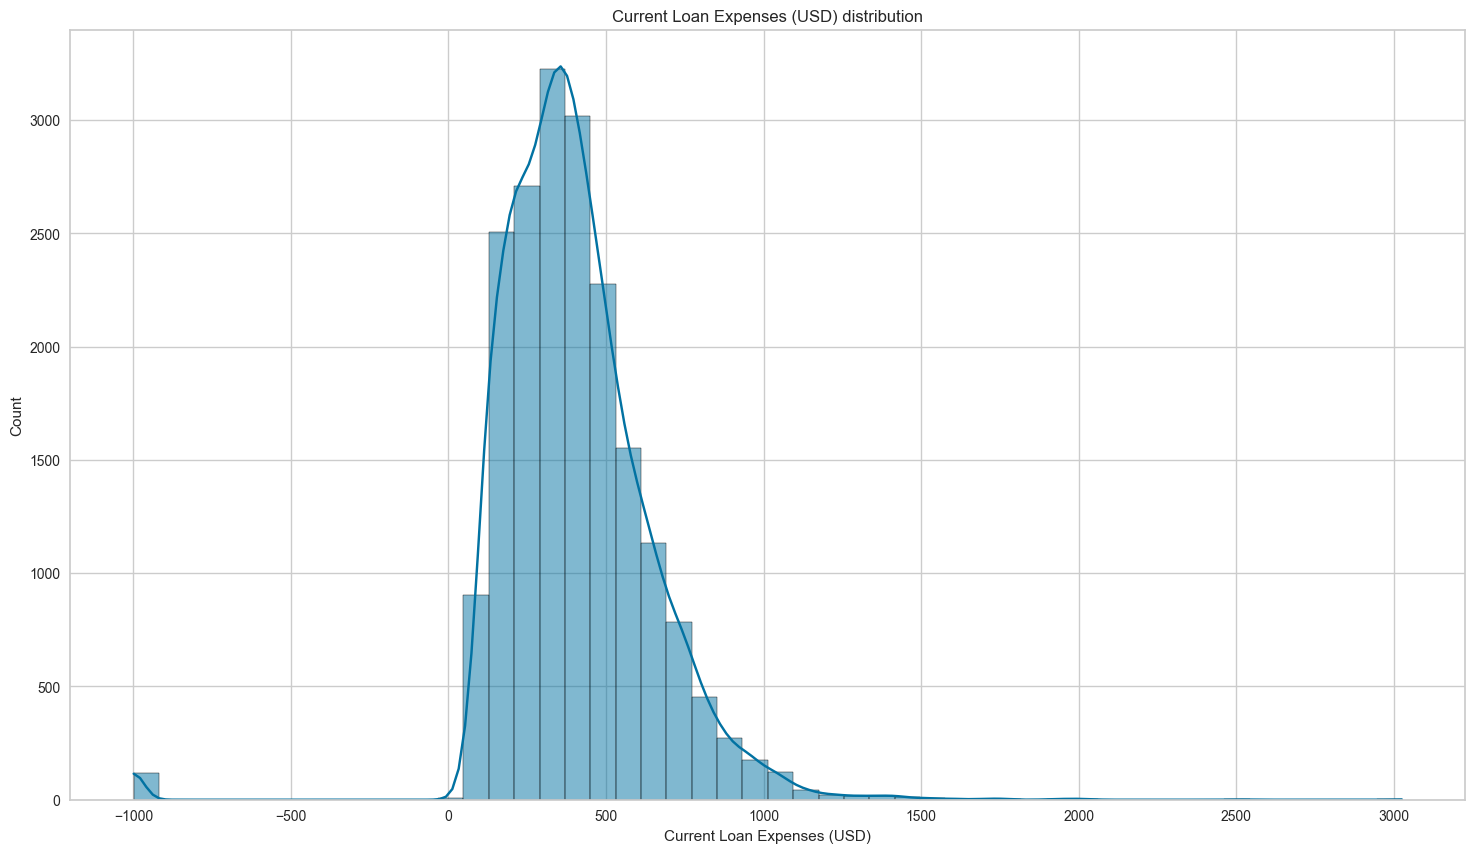

In [162]:
create_hist_plot(loan_amt_train_copy, 'Current Loan Expenses (USD)')

Interpretation:
- The mean current loan expenses is $375.275
- We have also some outliers
- The current loan expenses is positively skewed

### 2.3.10 Expense Type 1

In [163]:
gen_info_feat(loan_amt_train_copy,'Expense Type 1')

Description:
count     19500
unique        2
top           N
freq      12495
Name: Expense Type 1, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
N  12495         64.077
Y   7005         35.923


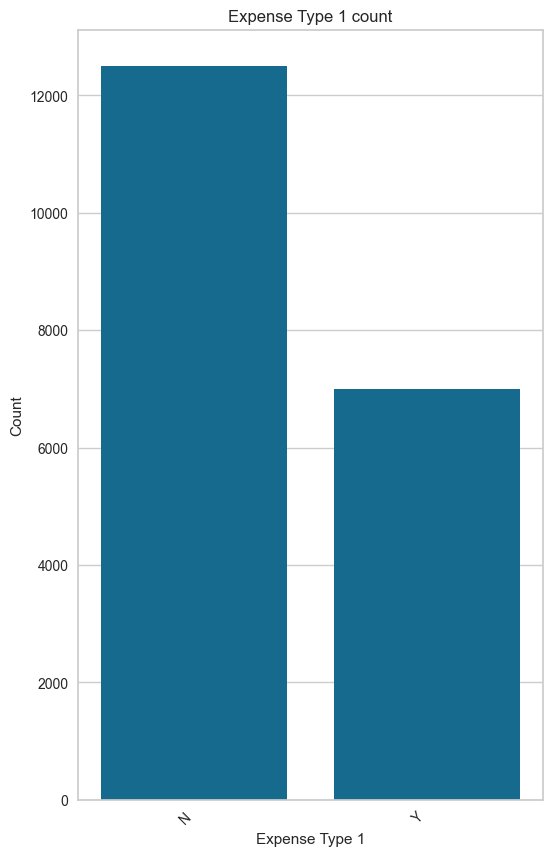

In [164]:
create_bar_plot(loan_amt_train_copy,'Expense Type 1')

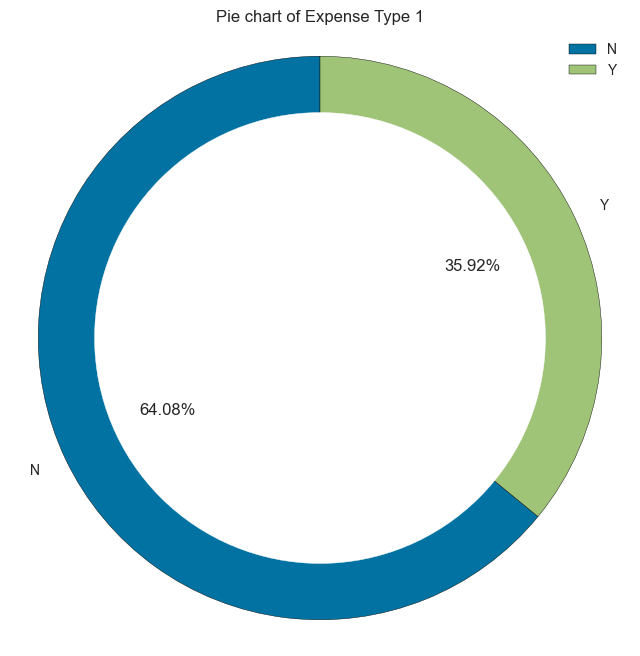

In [165]:
create_donnut_pie_chart(loan_amt_train_copy,'Expense Type 1')

Interpretation:
- More than half of applicants don't have the expenses type 1 on their loan.

### 2.3.11 Expense Type 2

In [166]:
gen_info_feat(loan_amt_train_copy,'Expense Type 2')

Description:
count     19500
unique        2
top           Y
freq      13135
Name: Expense Type 2, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
Y  13135         67.359
N   6365         32.641


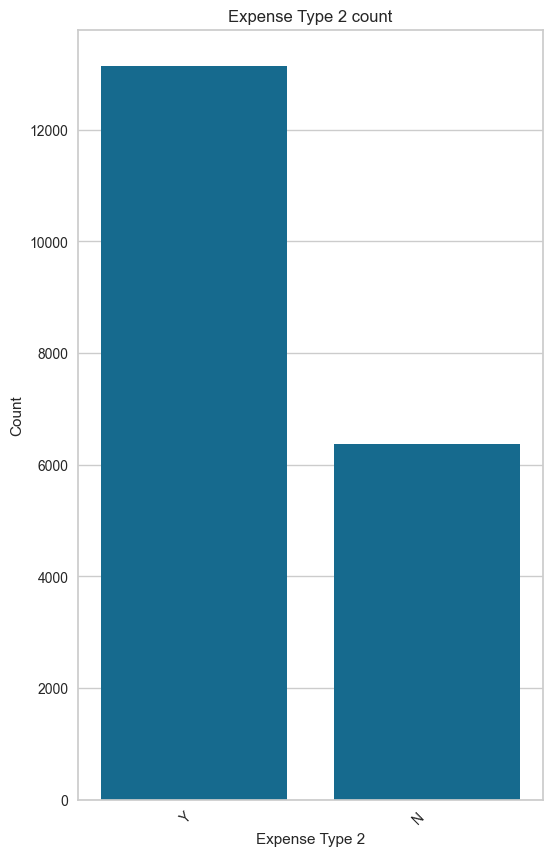

In [167]:
create_bar_plot(loan_amt_train_copy,'Expense Type 2')

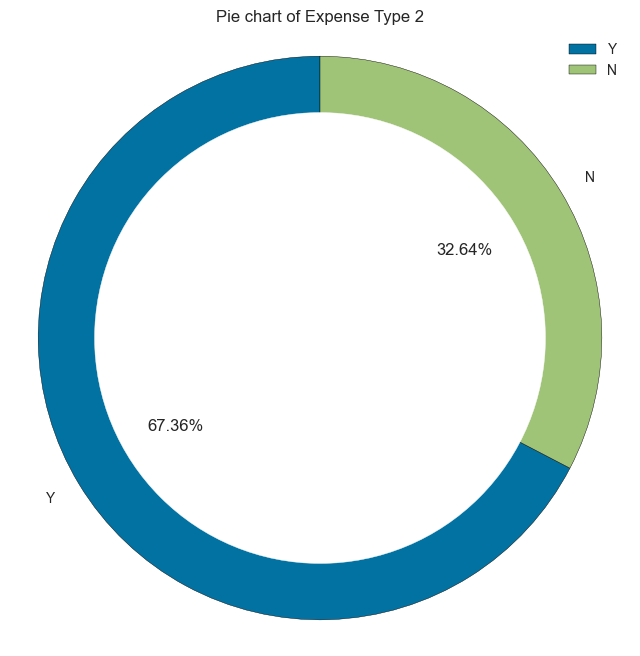

In [168]:
create_donnut_pie_chart(loan_amt_train_copy,'Expense Type 2')

Interpretation:
- The majority of applicants have expense type 2

### 2.3.12 Dependents

In [169]:
gen_info_feat(loan_amt_train_copy,'Dependents')

Description:
count   17885.000
mean        2.253
std         0.950
min         1.000
25%         2.000
50%         2.000
75%         3.000
max        10.000
Name: Dependents, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
        Count  Frequency (%)
2.000    8442         47.202
3.000    3752         20.978
1.000    3640         20.352
4.000    1782          9.964
5.000     233          1.303
6.000      31          0.173
7.000       3          0.017
8.000       1          0.006
10.000      1          0.006


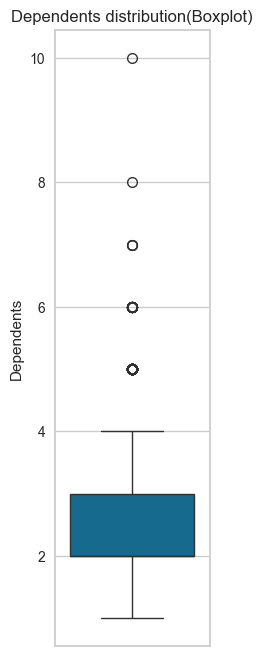

In [170]:
create_box_plot(loan_amt_train_copy, 'Dependents')

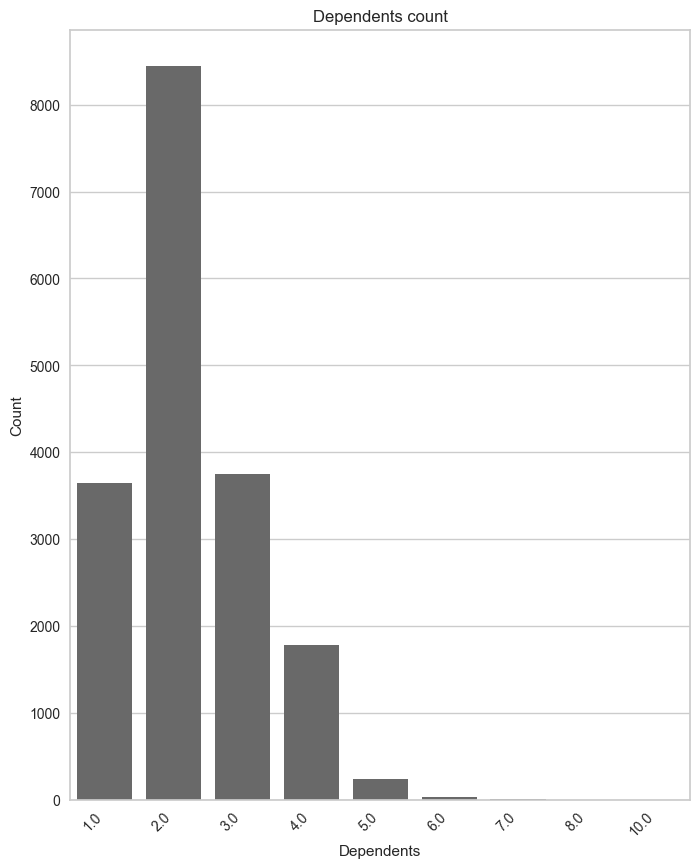

In [171]:
create_bar_plot(loan_amt_train_copy,'Dependents')

Interpretation:
- Most applicants have 2 dependents
- Then 1 and 3 dependents are the second most common
- Then 4 and 5 and so on

### 2.3.13 Credit Score

In [172]:
gen_info_feat(loan_amt_train_copy,'Credit Score')

Description:
count   18387.000
mean      739.578
std        72.369
min       580.000
25%       680.665
50%       739.650
75%       799.215
max       896.260
Name: Credit Score, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
-0.016710244346266123


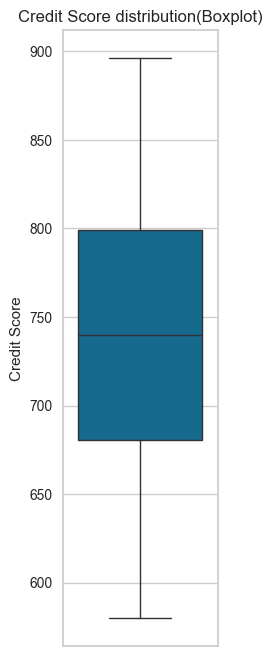

In [173]:
create_box_plot(loan_amt_train_copy, 'Credit Score')

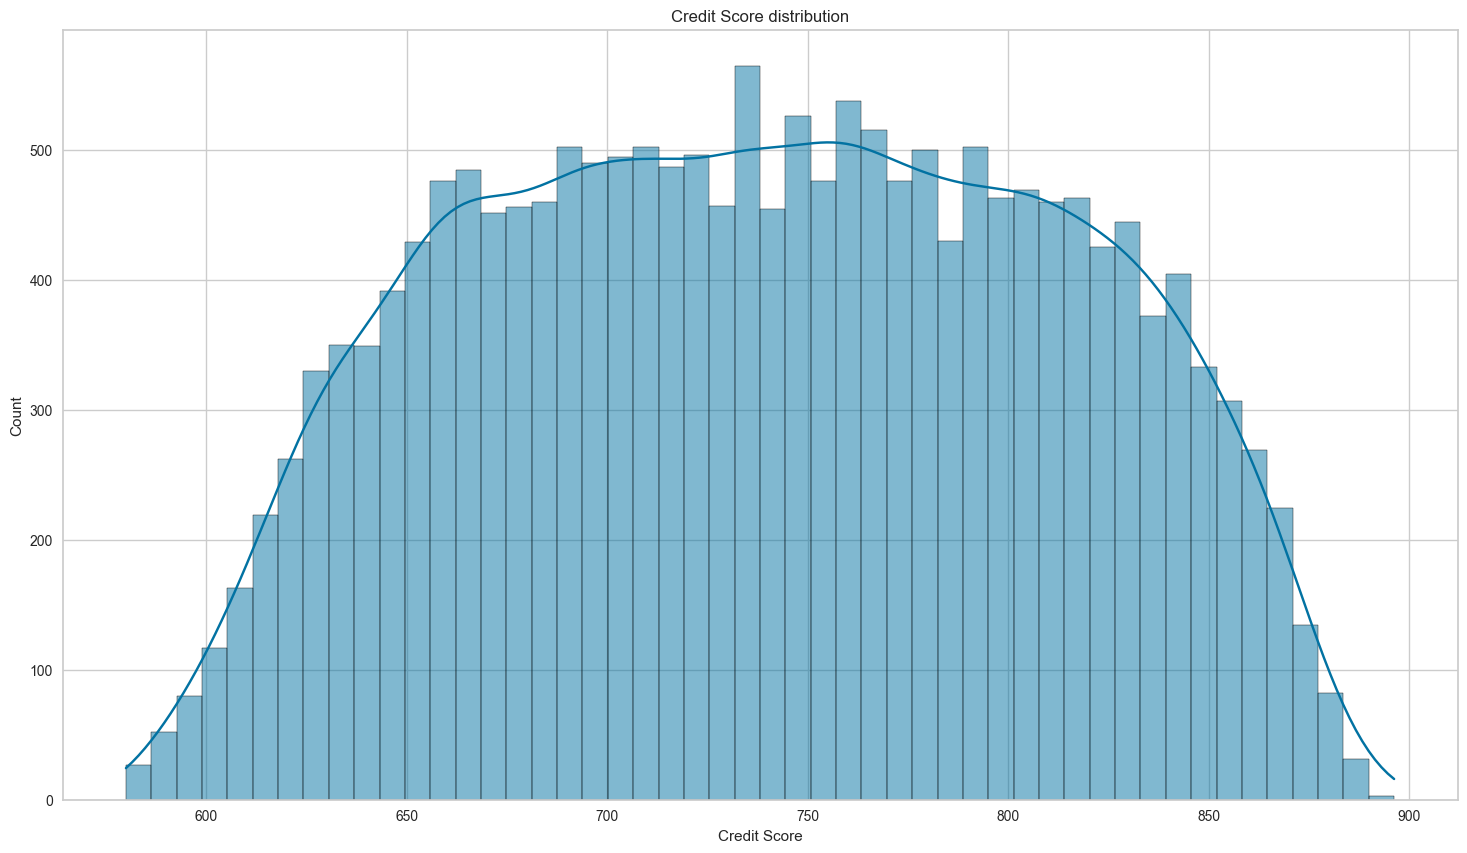

In [174]:
create_hist_plot(loan_amt_train_copy, 'Credit Score')

Interpretation:
- The mean and median of applicants's credit score is 739
- The credit score does not seems to be skewed but it is not normally distributed

### 2.3.14 Number of defaults

In [175]:
gen_info_feat(loan_amt_train_copy,'No. of Defaults')

Description:
count   19500.000
mean        0.193
std         0.395
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         1.000
Name: No. of Defaults, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  15740         80.718
1   3760         19.282


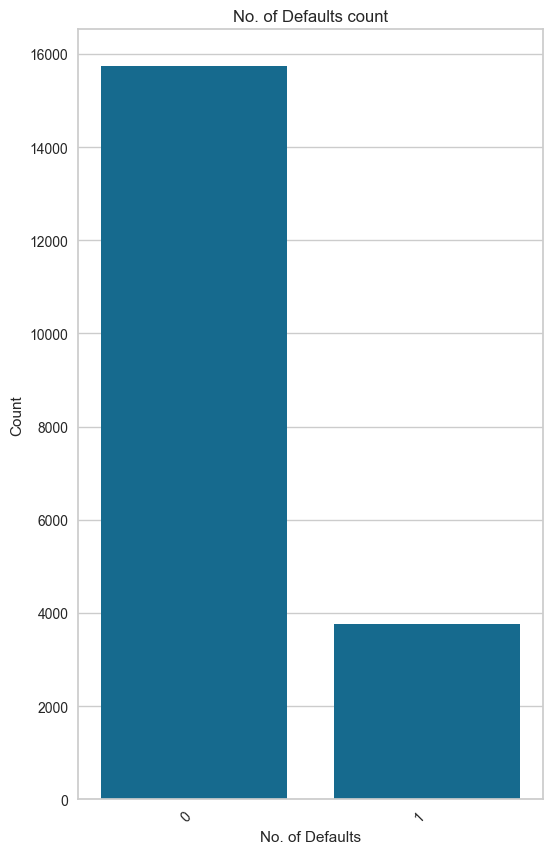

In [176]:
create_bar_plot(loan_amt_train_copy,'No. of Defaults')

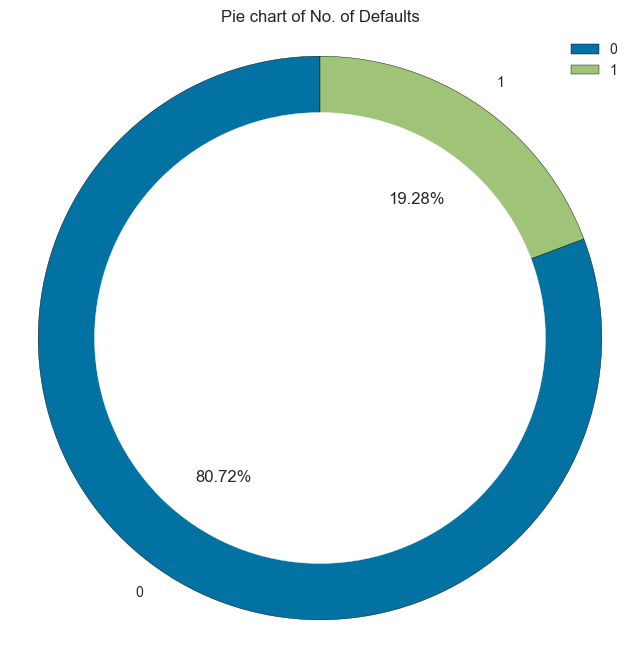

In [177]:
create_donnut_pie_chart(loan_amt_train_copy,'No. of Defaults')

Interpretation:
- 8 of 10 people don't have a any loan defaulted.

### 2.3.15 Has Active Credit Card

In [178]:
gen_info_feat(loan_amt_train_copy,'Has Active Credit Card')

Description:
count      18509
unique         3
top       Active
freq        6344
Name: Has Active Credit Card, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
             Count  Frequency (%)
Active        6344         34.275
Inactive      6174         33.357
Unpossessed   5991         32.368


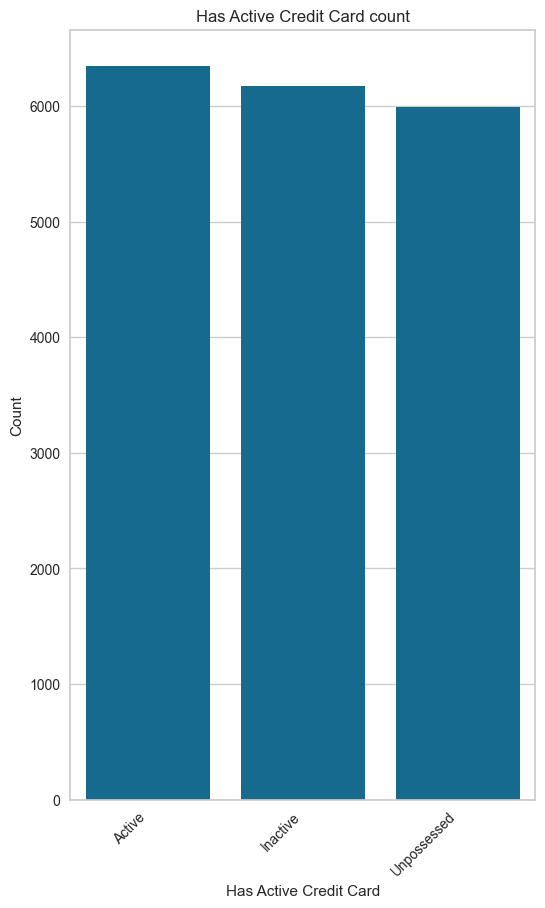

In [179]:
create_bar_plot(loan_amt_train_copy,'Has Active Credit Card')

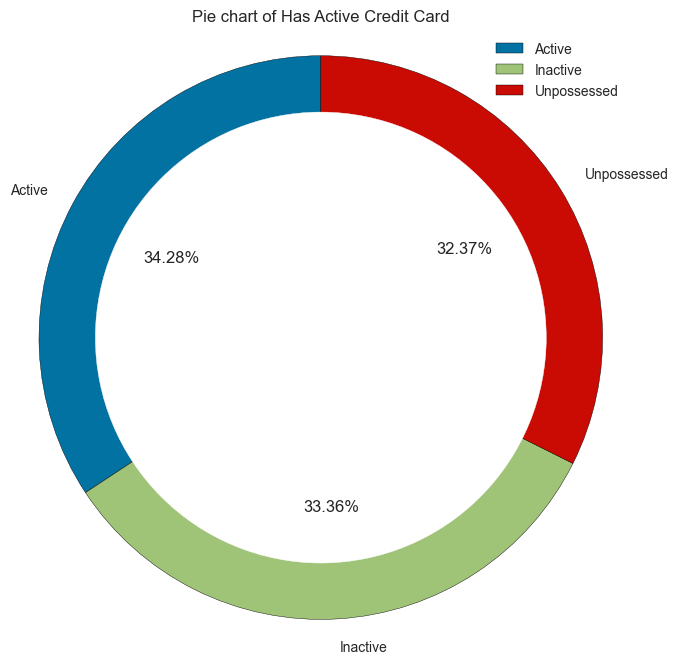

In [180]:
create_donnut_pie_chart(loan_amt_train_copy,'Has Active Credit Card')

Interpretation:
- We have almost an equal amount of people with an active, inactive and unpossessed credit card.

### 2.3.16 Property Age

In [181]:
gen_info_feat(loan_amt_train_copy,'Property Age')

Description:
count    44.808
mean      6.989
std       4.783
min       1.037
25%       4.518
50%       6.081
75%       8.464
max     336.663
Name: Property Age, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
22.51121044218723


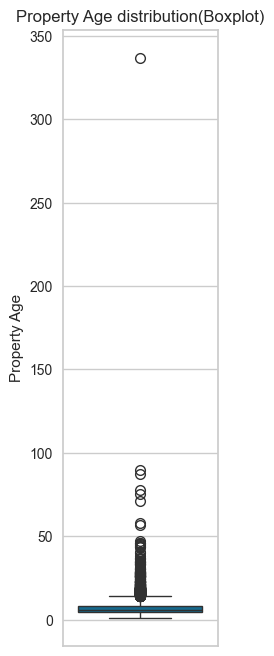

In [182]:
create_box_plot(loan_amt_train_copy, 'Property Age')

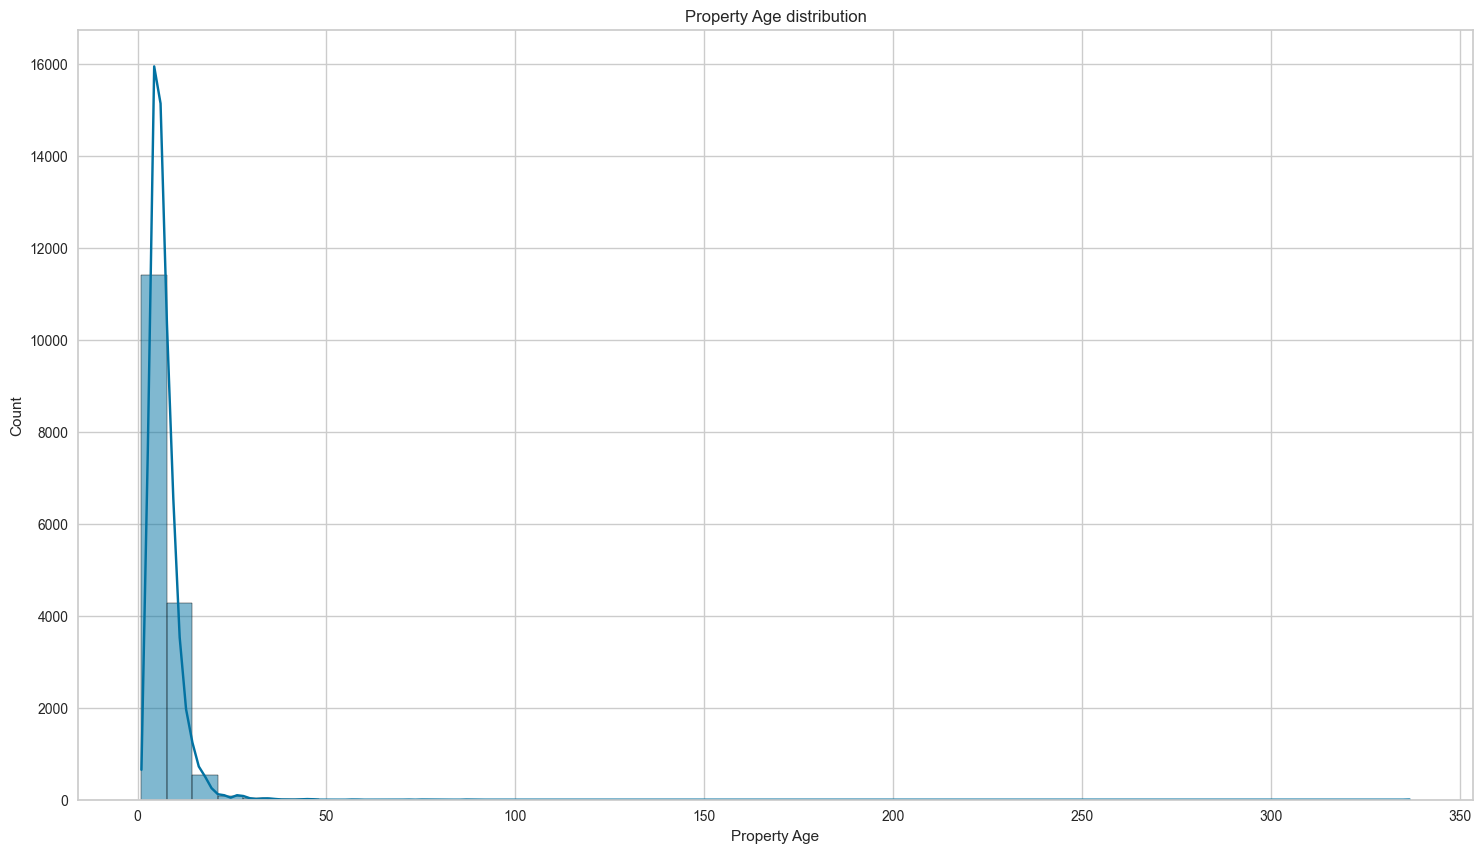

In [183]:
create_hist_plot(loan_amt_train_copy, 'Property Age')

Interpretation:
- Assuming that the property age is expressed in days, most of properties have a median age of 2231 days(6.1 years)
- The property age distribution is positively skewed


### 2.3.17 Property Type

In [184]:
gen_info_feat(loan_amt_train_copy,'Property Type')

Description:
count   19500.000
mean        2.470
std         1.120
min         1.000
25%         1.000
50%         2.000
75%         3.000
max         4.000
Name: Property Type, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
1   5077         26.036
2   4913         25.195
3   4787         24.549
4   4723         24.221


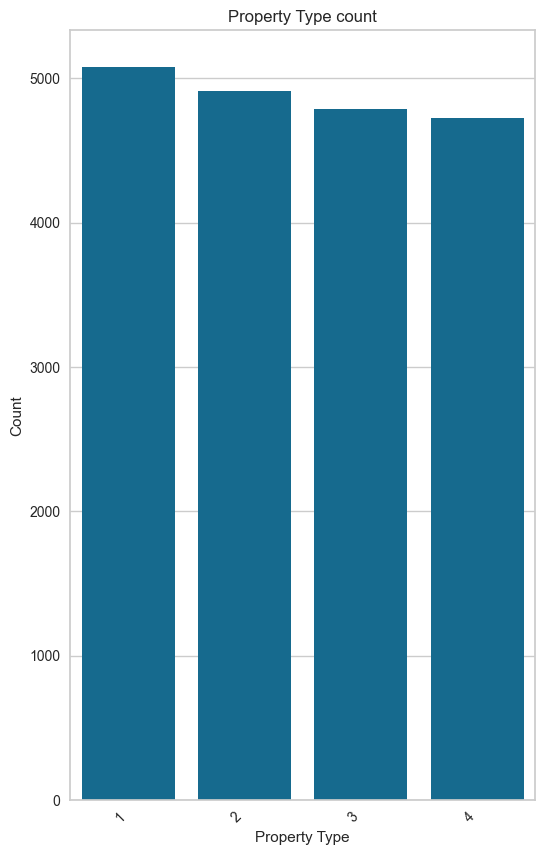

In [185]:
create_bar_plot(loan_amt_train_copy,'Property Type')

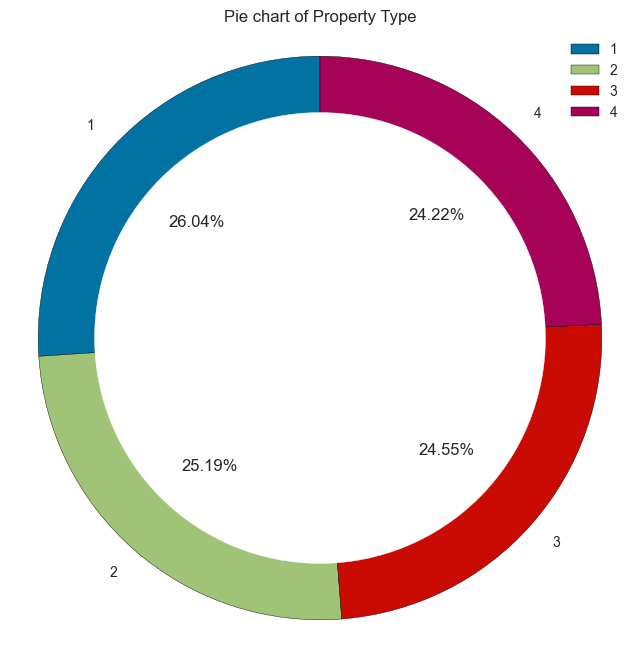

In [186]:
create_donnut_pie_chart(loan_amt_train_copy,'Property Type')

Interpretation:
- We have almost an equal amount of property types, each with 25%

### 2.3.18 Property Location

In [187]:
gen_info_feat(loan_amt_train_copy,'Property Location')

Description:
count          19282
unique             3
top       Semi-Urban
freq            6723
Name: Property Location, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency (%)
Semi-Urban   6723         34.867
Rural        6549         33.964
Urban        6010         31.169


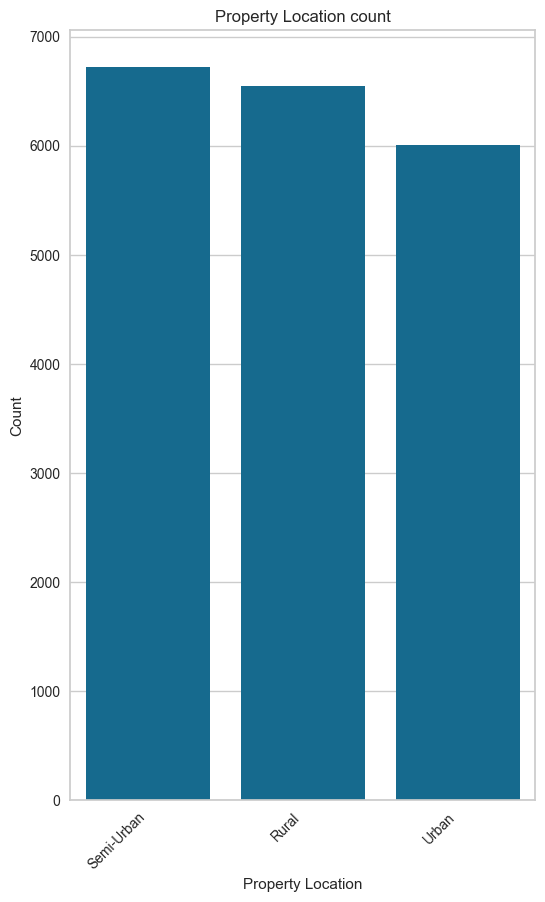

In [188]:
create_bar_plot(loan_amt_train_copy,'Property Location')

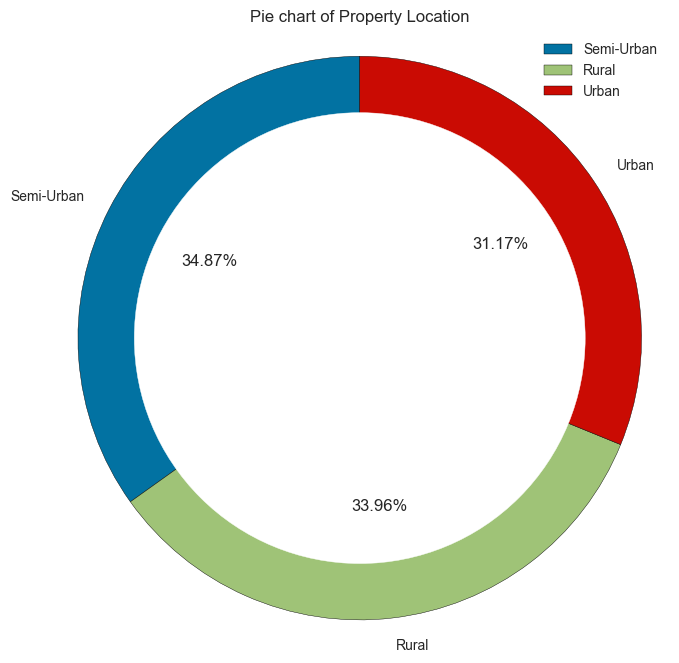

In [189]:
create_donnut_pie_chart(loan_amt_train_copy,'Property Location')

Interpretation:
- All the 3 property location are almost equally distributed at around 33%

### 2.3.19 Co-Applicant

In [190]:
gen_info_feat(loan_amt_train_copy,'Co-Applicant')

Description:
count   19500.000
mean       -4.274
std        71.420
min      -999.000
25%         1.000
50%         1.000
75%         1.000
max         1.000
Name: Co-Applicant, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
      Count  Frequency (%)
 1    16560         84.923
 0     2840         14.564
-999    100          0.513


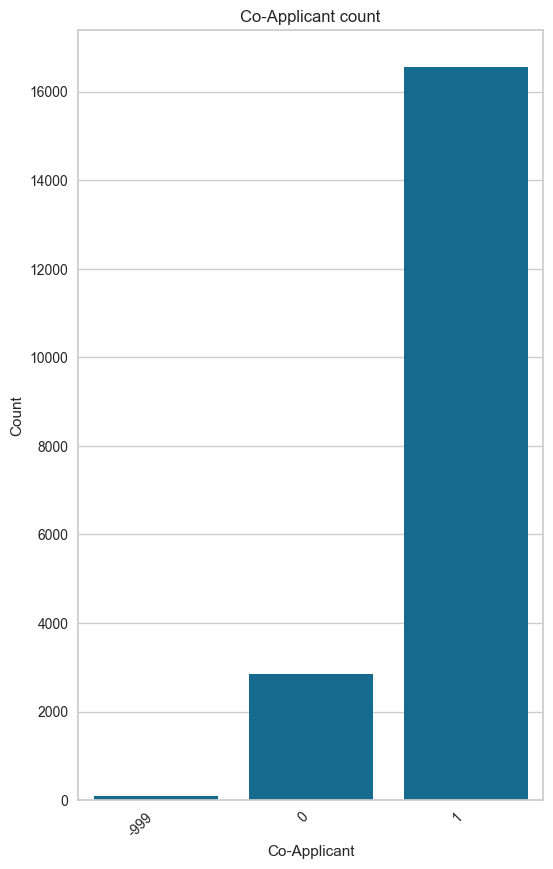

In [191]:
create_bar_plot(loan_amt_train_copy,'Co-Applicant')

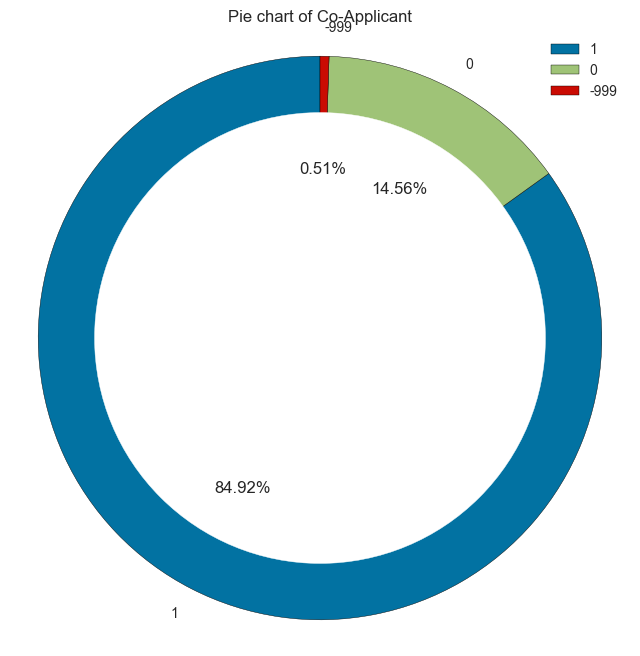

In [192]:
create_donnut_pie_chart(loan_amt_train_copy,'Co-Applicant')

Interpretation:
- Most of applicants have a co-applicants (~85%)
- 14% of applicants don't have a co-applicant
- The rest are unknown (~0.5%)

### 2.3.20 Property Price

In [193]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
gen_info_feat(loan_amt_train_copy,'Property Price')

Description:
count     19500.000
mean     131933.258
std       93678.679
min        -999.000
25%       60658.740
50%      110305.925
75%      178974.645
max     1077966.730
Name: Property Price, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.4111221025421703


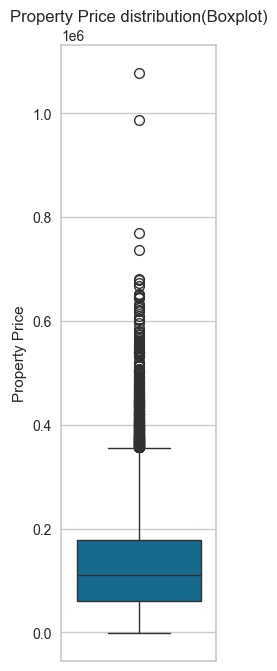

In [194]:
create_box_plot(loan_amt_train_copy, 'Property Price')

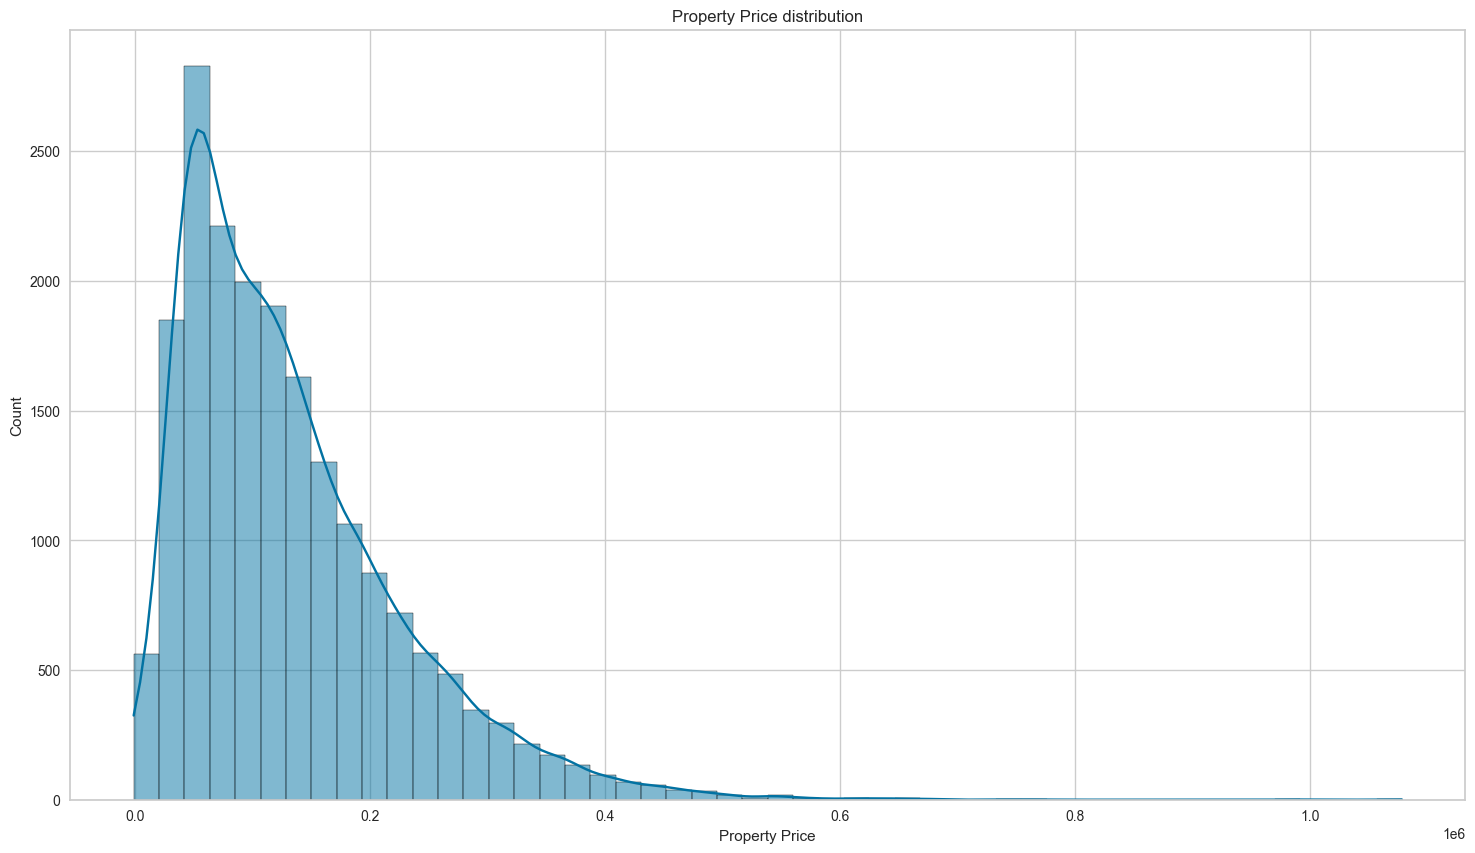

In [195]:
create_hist_plot(loan_amt_train_copy, 'Property Price')

Interpretation:
- The median property price is $110168.710
- We have quite a number of outliers
- The distribution of the property price is skewed to the right

### 2.3.21 Loan Sanction Amount

In [196]:
gen_info_feat(loan_amt_train_copy,'Loan Sanction Amount (USD)')

Description:
count    19268.000
mean     47577.797
std      48296.582
min       -999.000
25%          0.000
50%      35013.020
75%      74079.872
max     395368.740
Name: Loan Sanction Amount (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.2140701702158658


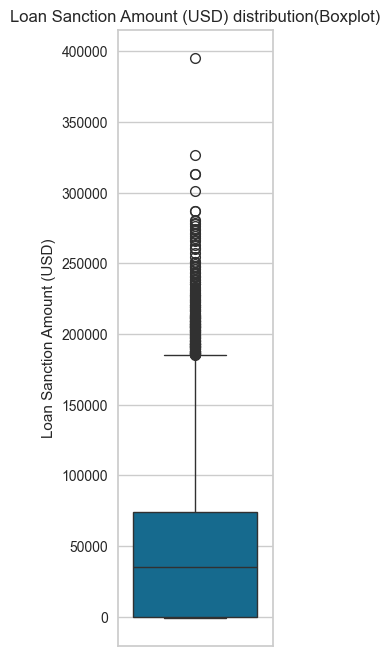

In [197]:
create_box_plot(loan_amt_train_copy, 'Loan Sanction Amount (USD)')

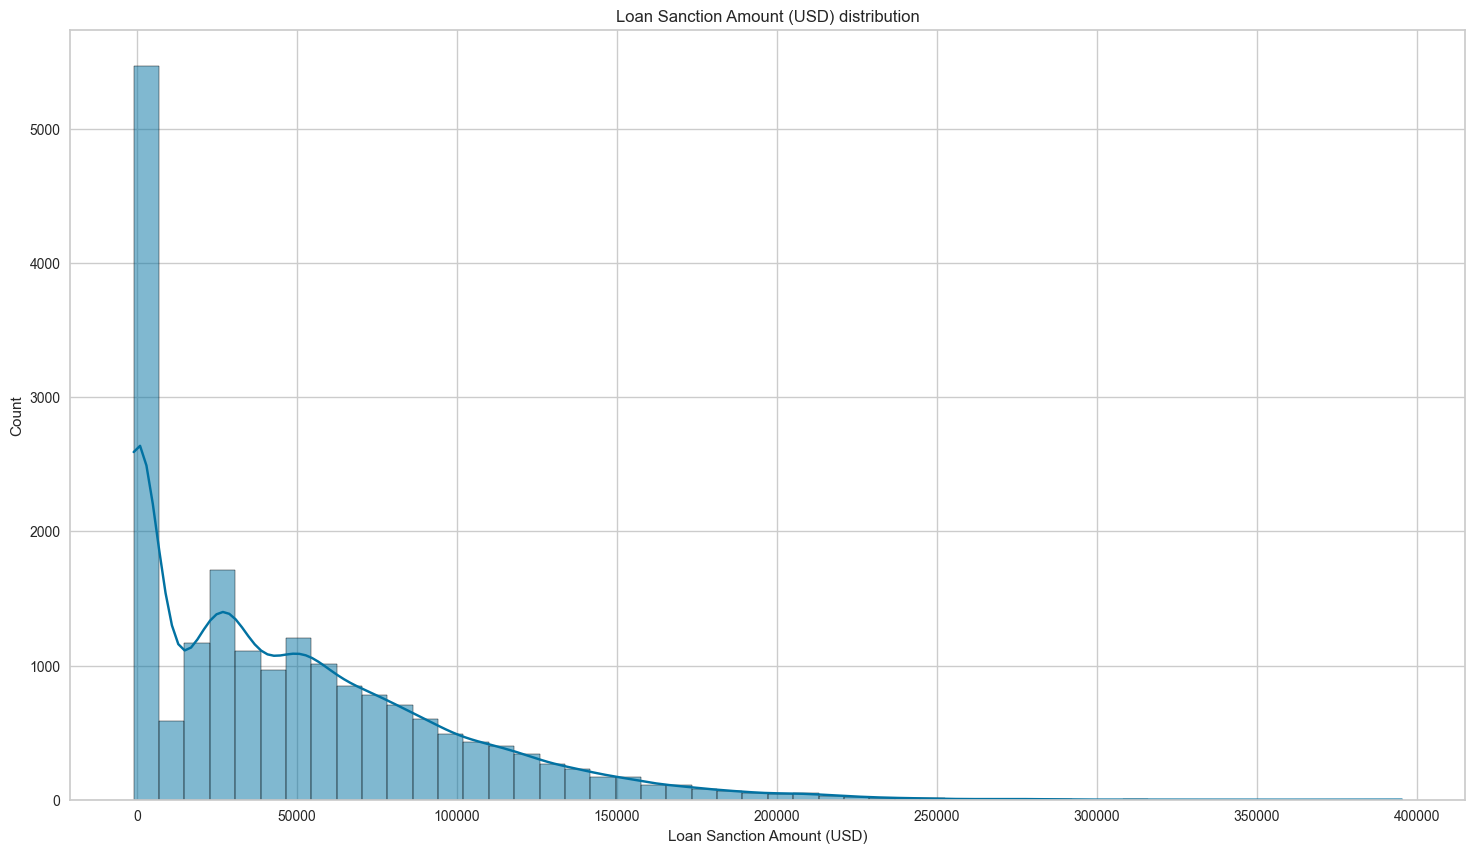

In [198]:
create_hist_plot(loan_amt_train_copy, 'Loan Sanction Amount (USD)')

Interpretation:
- The median loan sanction amount is $35273.020
- We have quite a number of outliers
- The distribution of the loan sanction amount is skewed to the right

## 2.4 Bivariate Analysis

### 2.4.1 Numerical vs numerical features (Correlation & scatter plots)

#### 2.4.1.1 Scatter plots

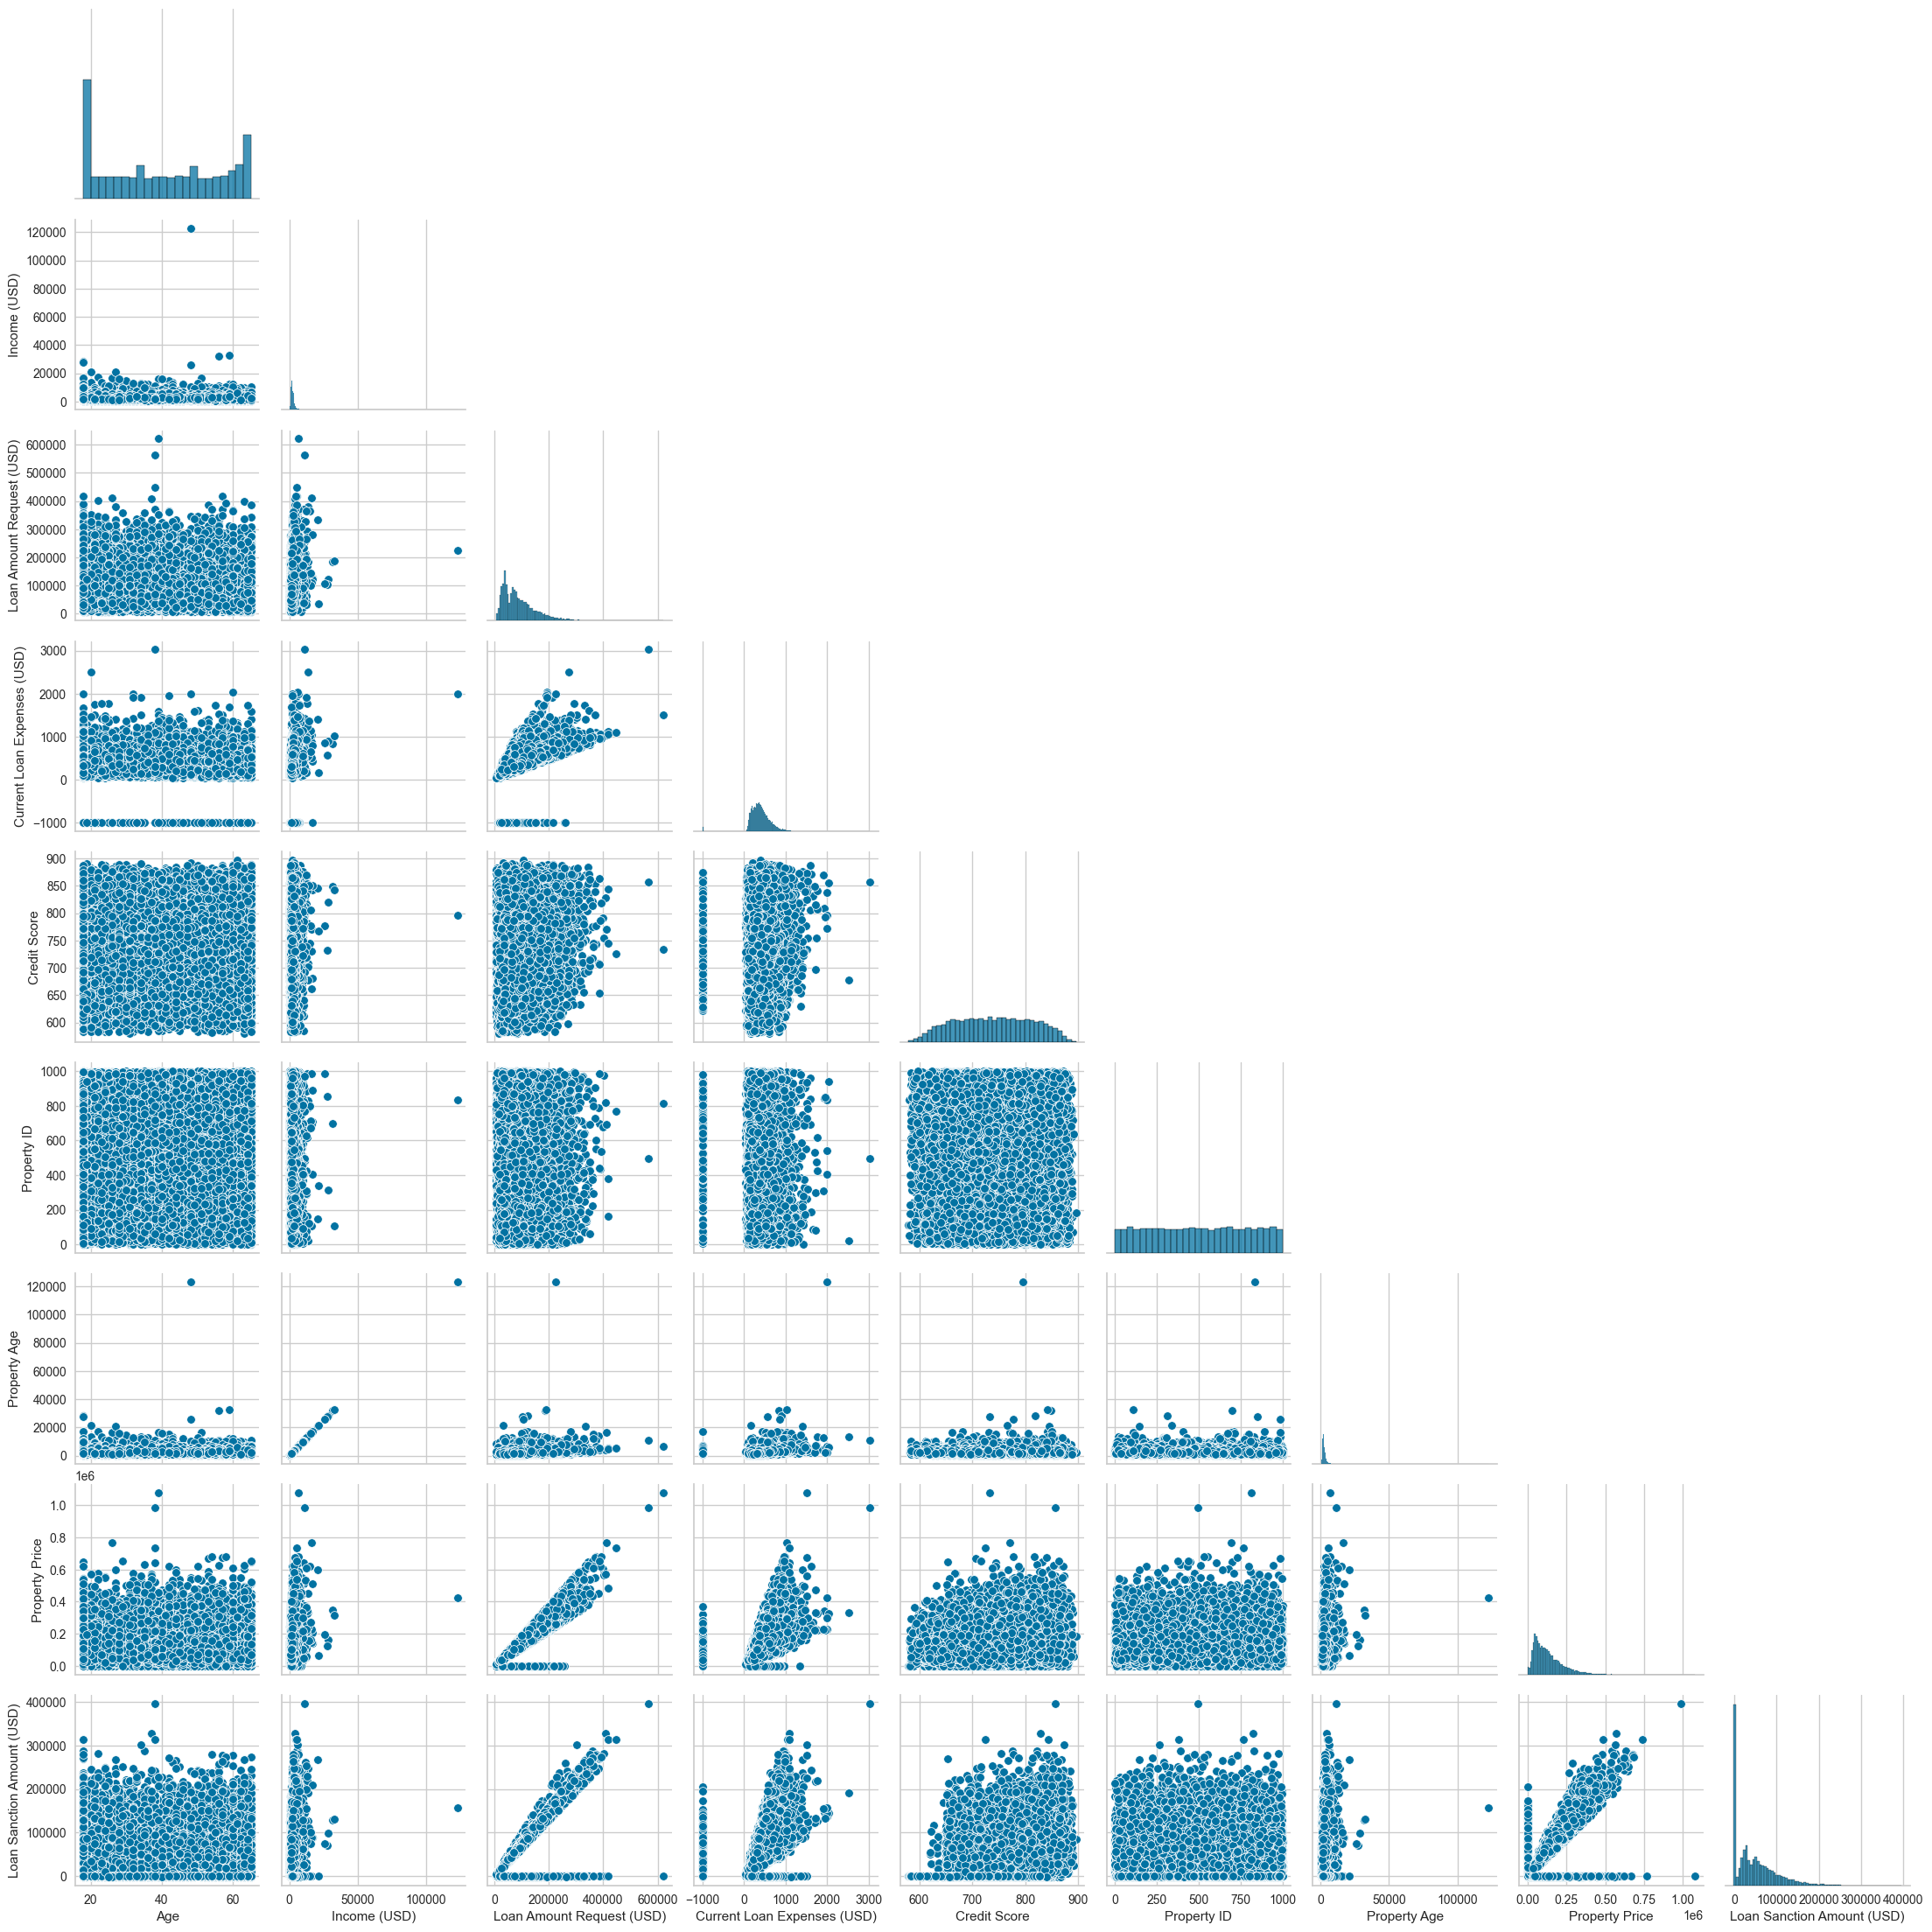

In [199]:
sns.pairplot(loan_amt_train_copy.drop(['Dependents','No. of Defaults','Property Type','Co-Applicant'],axis=1),corner=True)
plt.show()

Interpretation:
- There is a positive correlation between the loan amount request and the current loan expenses.
- There is also a perfect positive correlation between the income and the property age.
- There is a colleration between property price and loan amount request.
- There is a colleration between loan sanction amount and loan amount request.
- We also find a correlation between the property price and current loan expenses.
- There is a correlation between loan sanction amount and current loan expenses.
- There is a correlation between property price and loan sanction amount.

In [200]:
loan_amt_train_copy[['Loan Amount Request (USD)','Loan Sanction Amount (USD)']]

Loan Amount Request (USD)  Loan Sanction Amount (USD)
0                     182727.650                  118772.970
1                      29111.920                   18922.750
2                      86199.290                       0.000
3                      74086.260                   59269.010
4                      45274.480                   31692.140
...                          ...                         ...
19495                 122864.440                   86005.110
19496                 101151.000                   65748.150
19497                  91833.600                   64283.520
19498                  62065.250                   43445.680
19499                  69496.720                   55597.380

[19500 rows x 2 columns]

##### 2.4.1.1.1 Loan amount request vs current loan expenses

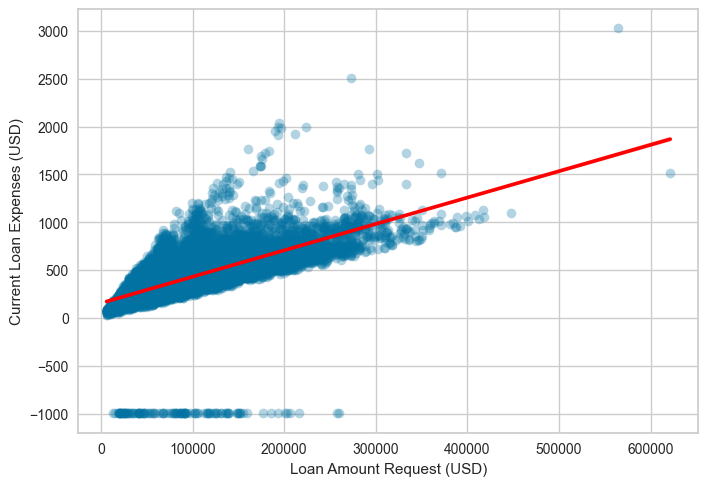

In [201]:
sns.regplot(x='Loan Amount Request (USD)',y='Current Loan Expenses (USD)',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The more the loan amount requested, the more the current loan expenses.

##### 2.4.1.1.2 Income vs property age

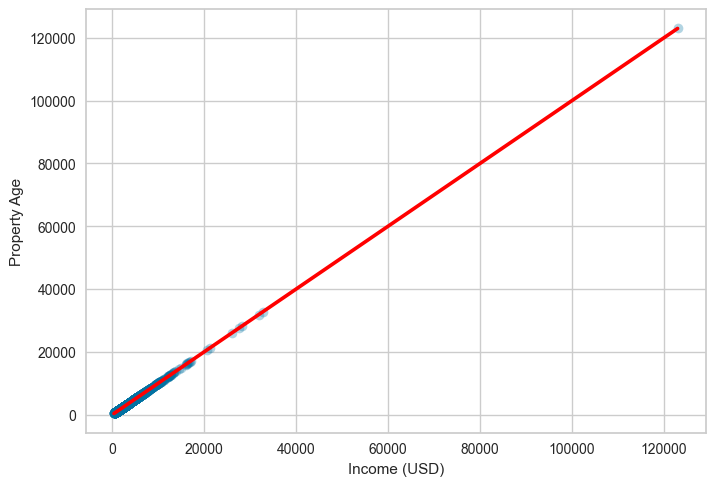

In [202]:
sns.regplot(x='Income (USD)',y='Property Age',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- We have a perfect correlation between the income and the property age. The more the income, the older the property.

##### 2.4.1.1.3 Loan amount request vs property price

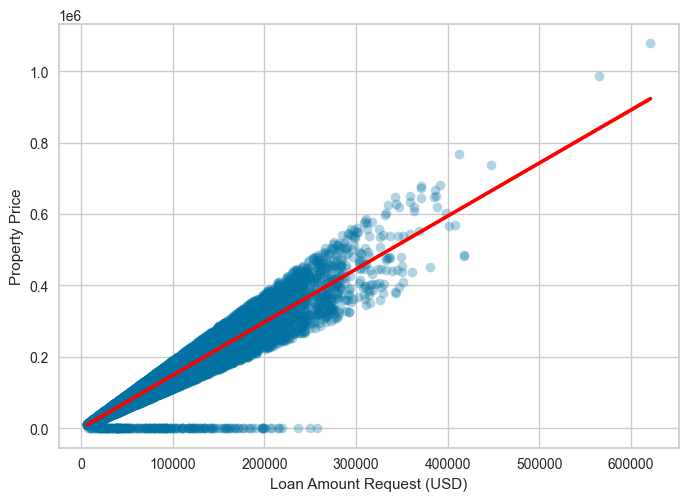

In [203]:
sns.regplot(x='Loan Amount Request (USD)',y='Property Price',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The more amount of loan requested, the more expensive the property price.

##### 2.4.1.1.4 Loan amount request vs loan sanction amount

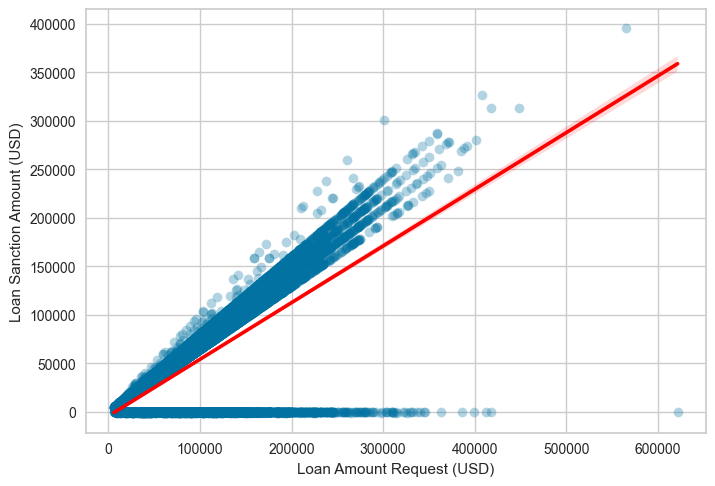

In [204]:
sns.regplot(x='Loan Amount Request (USD)',y='Loan Sanction Amount (USD)',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The loan amount requested increase with the loan sanction amount

##### 2.4.1.1.5 Current loan expenses vs Property price

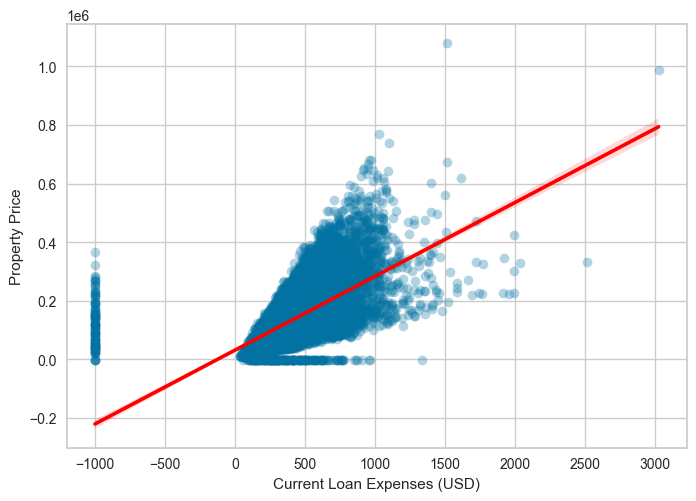

In [205]:
sns.regplot(x='Current Loan Expenses (USD)',y='Property Price',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- Loan expenses generally increases with the property price.

##### 2.4.1.1.6 Current loan expenses vs Loan sanctioned amount

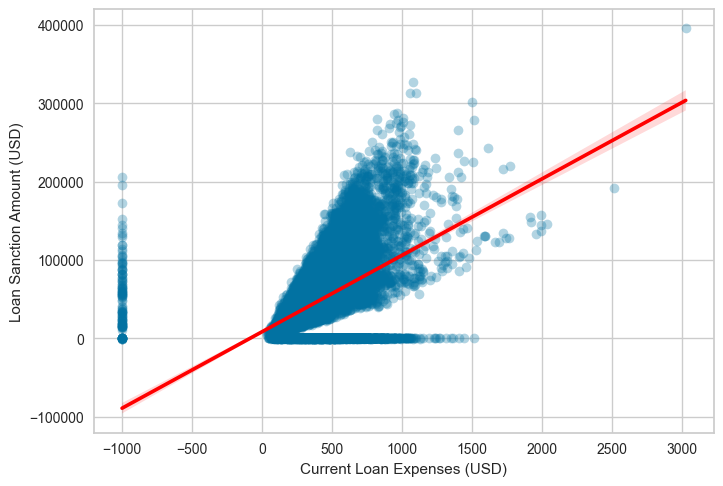

In [206]:
sns.regplot(x='Current Loan Expenses (USD)',y='Loan Sanction Amount (USD)',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The loan expenses increase as the loan sanction amount increases.

##### 2.4.1.1.7 Property price vs loan sanction amount

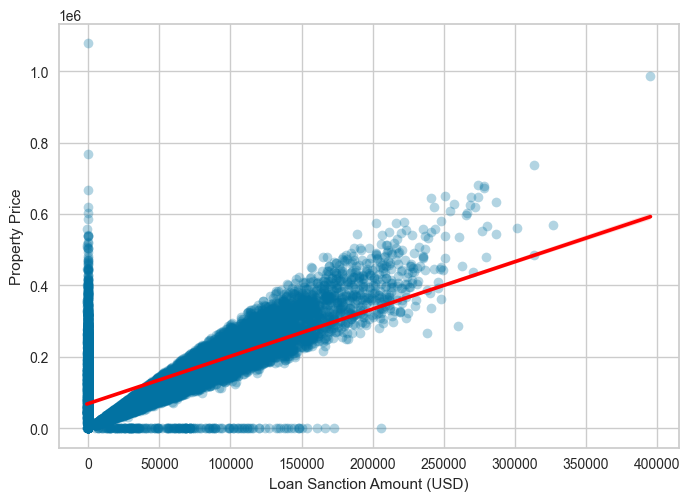

In [207]:
sns.regplot(x='Loan Sanction Amount (USD)',y='Property Price',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- Loan sanction amount and the property price are positively correlated.

#### 2.4.1.2 Correlation analysis

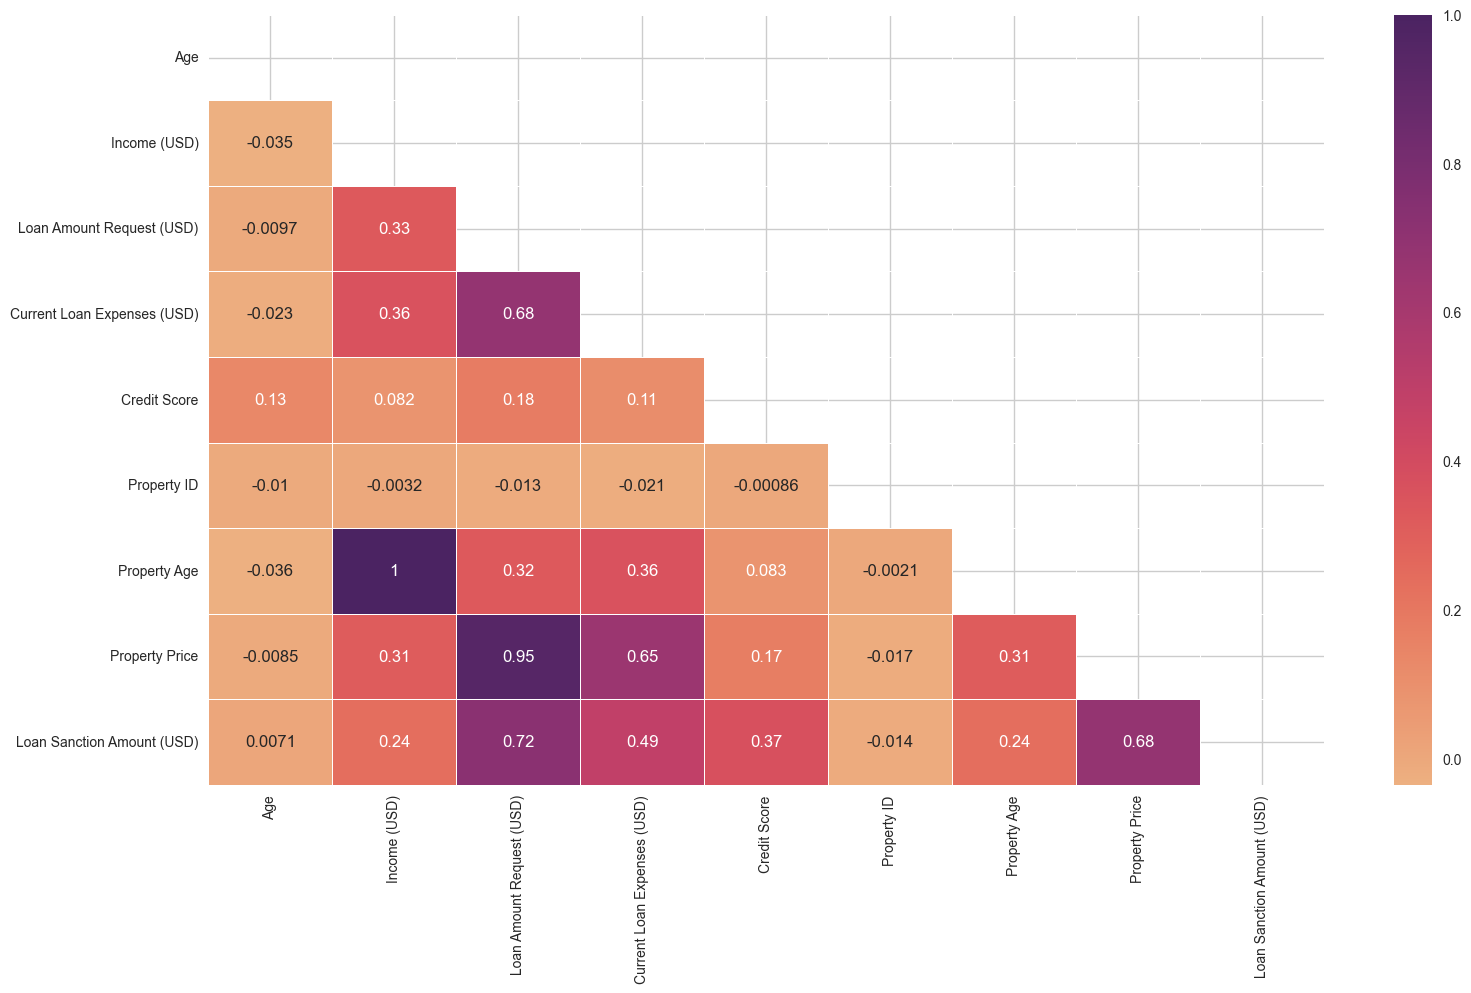

In [208]:
loan_amt_train_copy_corr = loan_amt_train_copy.drop(['Dependents','No. of Defaults','Property Type','Co-Applicant'],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(loan_amt_train_copy_corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(loan_amt_train_copy_corr, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

Interpretation:
- Income is highly correlated with Property age
- Loan Amount Request is highly correlated with Property Price
- Loan Amount Request is highly correlated with Loan Sanction Amount
- Current Loan Expenses is correlated with Property Price
- Current Loan Expenses is correlated with Loan Sanction Amount
- Loan Sanction Amount is highly correlated with Property Price


In [209]:
loan_amt_train_copy.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [210]:
loan_amt_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19500 entries, 0 to 19499
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  19500 non-null  object 
 1   Name                         19500 non-null  object 
 2   Gender                       19461 non-null  object 
 3   Age                          19500 non-null  int64  
 4   Income (USD)                 16526 non-null  float64
 5   Income Stability             18468 non-null  object 
 6   Profession                   19500 non-null  object 
 7   Type of Employment           14761 non-null  object 
 8   Location                     19500 non-null  object 
 9   Loan Amount Request (USD)    19500 non-null  float64
 10  Current Loan Expenses (USD)  19396 non-null  float64
 11  Expense Type 1               19500 non-null  object 
 12  Expense Type 2               19500 non-null  object 
 13  Dependents      

#### 2.4.2 Numerical vs categorical features (ANOVA)

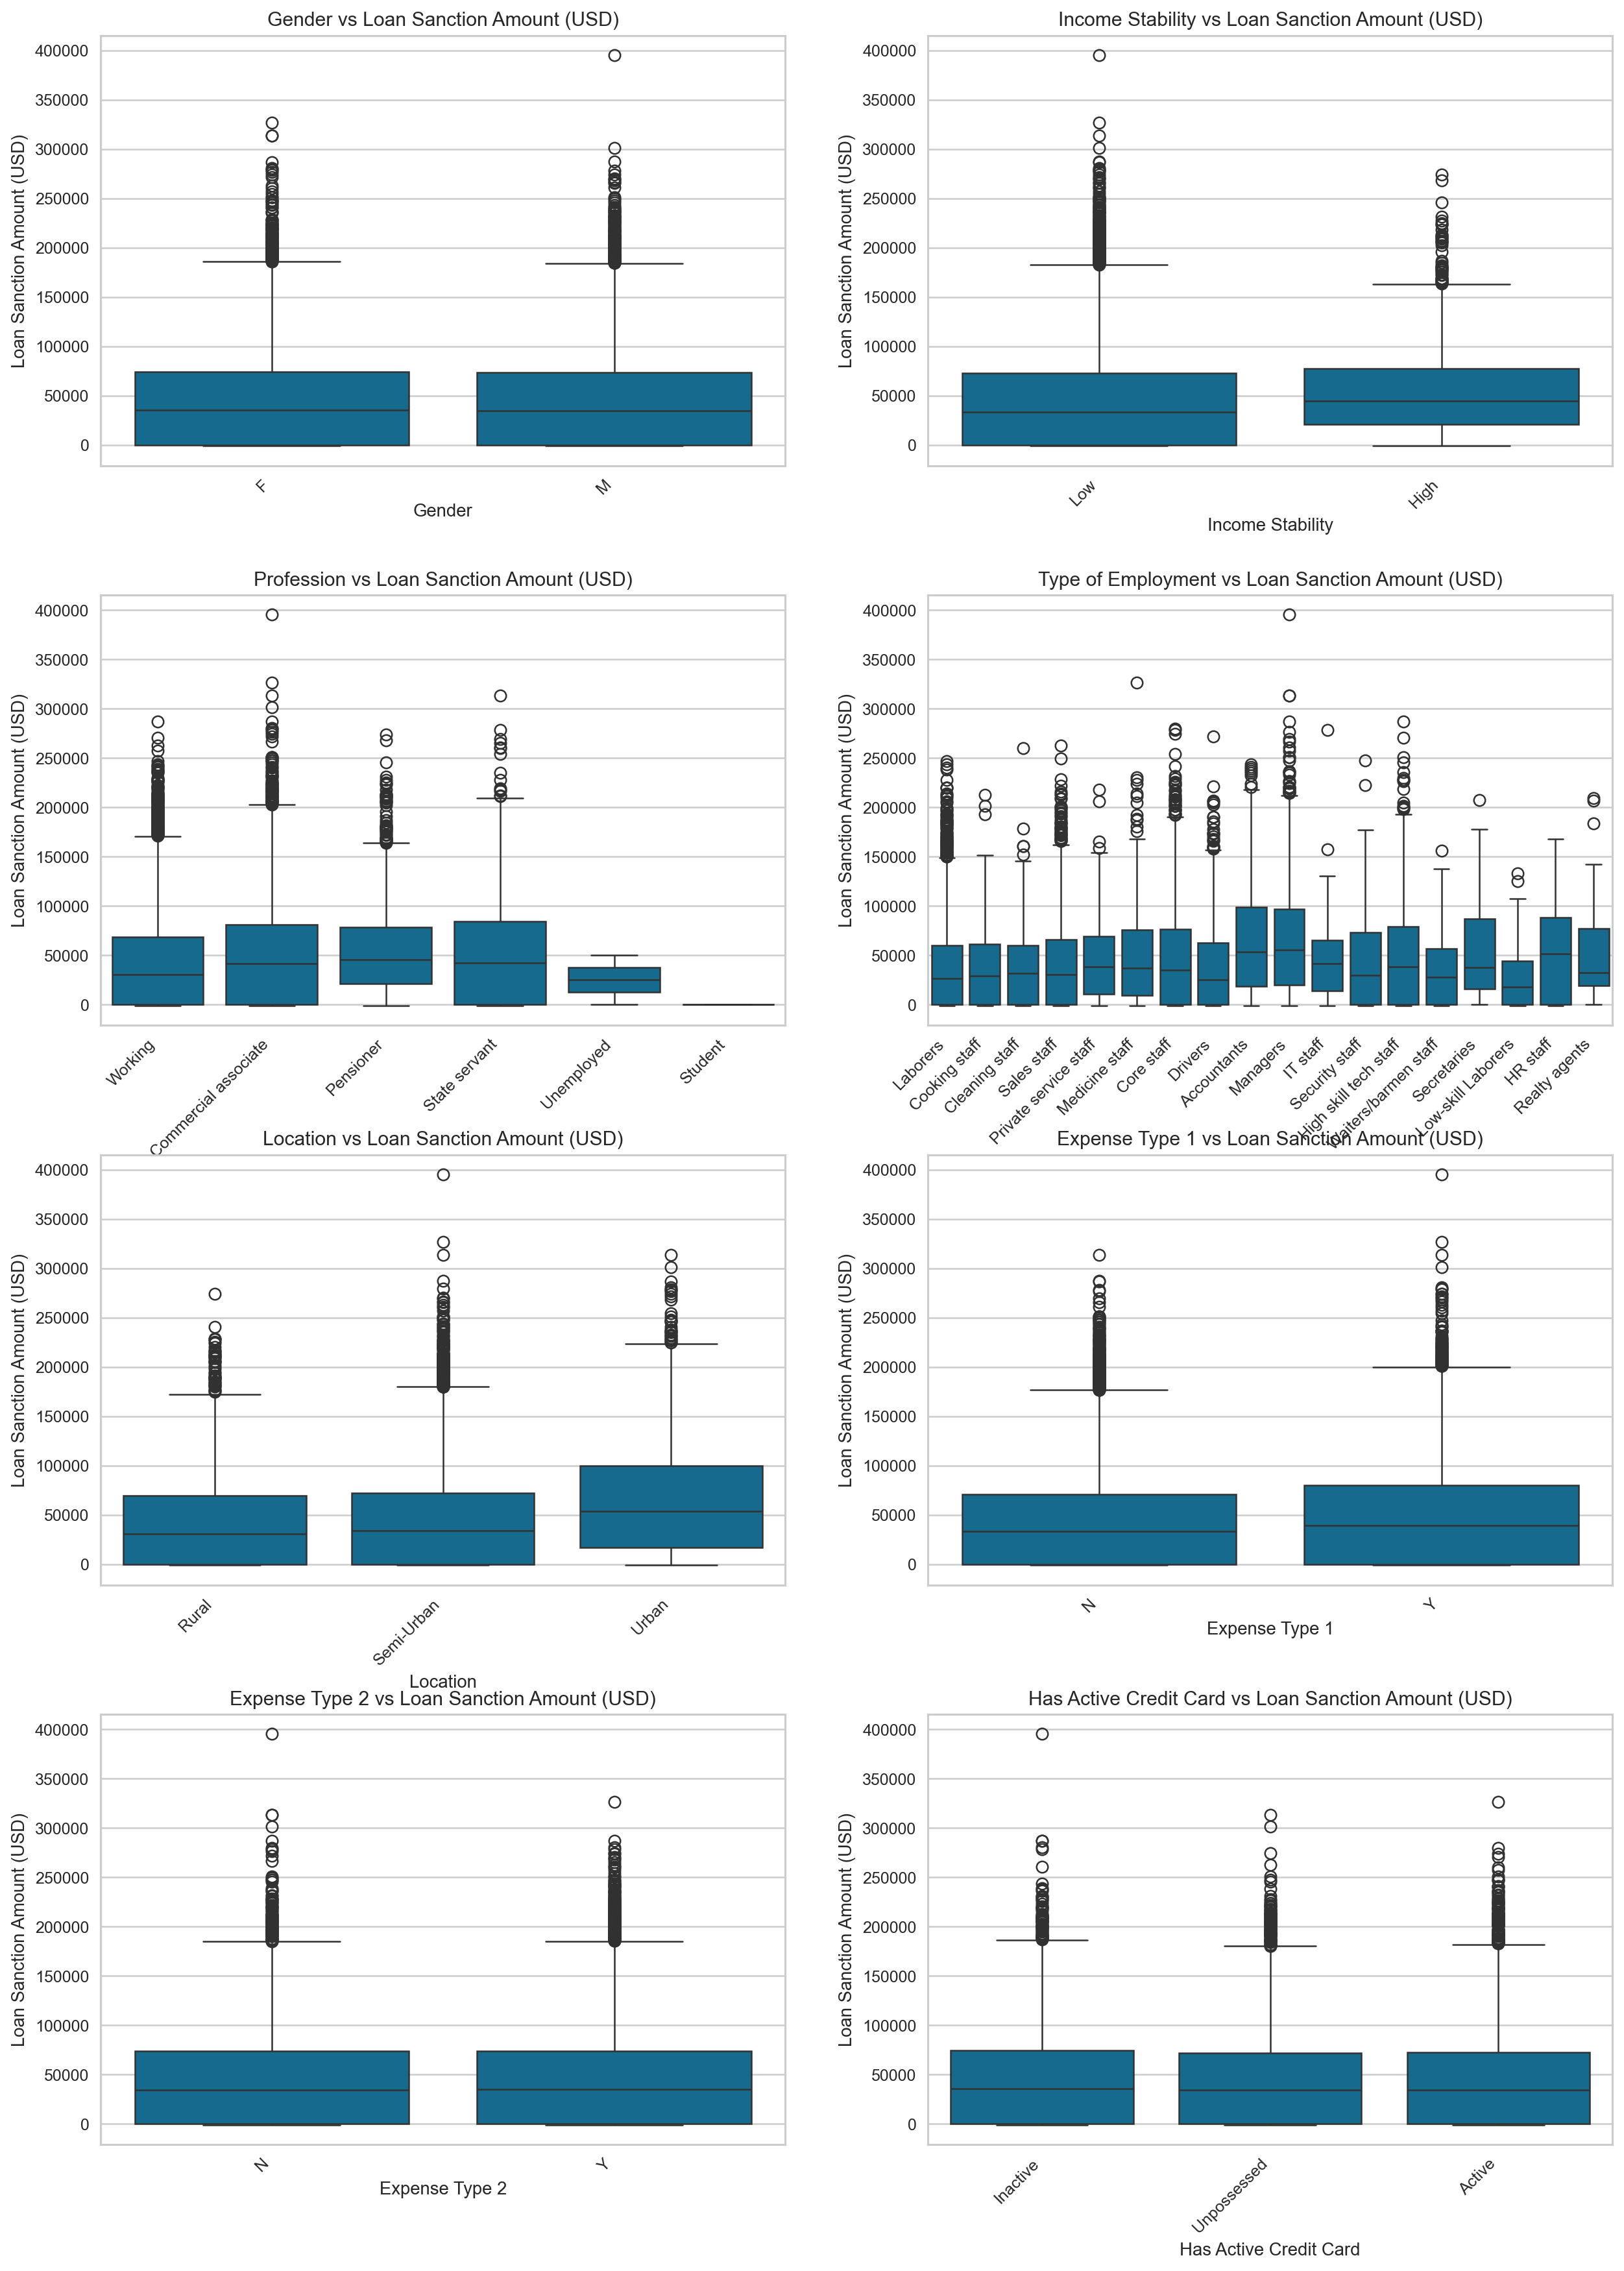

In [211]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender','Income Stability','Profession','Type of Employment','Location','Expense Type 1','Expense Type 2','Has Active Credit Card','Property Location']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=loan_amt_train_copy[cat_features[cat_ft_count]],y=loan_amt_train_copy['Loan Sanction Amount (USD)'])
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs Loan Sanction Amount (USD)")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Loan Sanction Amount (USD)')
            cat_ft_count += 1
    break

Interpretation:
- People with high income stability were given a high loan sanction amount
- Managers, HR staff and accounts received a median loan sanction amount of $5000
- People who live in urban area received the highest loan sanction amount

# 3. Prepare the data

## 3.1 Transformations to be done on each feature

Customer ID:
- Drop the feature

Name:
- Drop the feature


Gender:
- One hot encoding
- Missing value(Replace with the mode)


Age:
-	Min-max enc

Income:
-	Min-max enc
-	Outliers handler
-	Missing value (Replace with median)
-   Fix skewness

Income stability:
-	One hot encoding
-	Missing value (replace with the mode)

Profession:
-	One hot encoding
-   Drop the rows with the least frequent profession (Student, Businessman, Unemployed)

Type of employment
-	Drop the feature

Location:
-	One hot encoding

Loan amount request:
-	Min-max enc
-	Outliers handler
-   Fix skewness

Current loan expenses:
-	-999 handler
-	Min-max enc
-	Outliers handler
-	Missing value (replace with median)
-   Fix skewness

Expenses type 1
-	One hot encoding

Expenses type 2
-	One hot encoding


Dependents:
-	Outliers handler
-   Missing value (replace with mode)

Credit score:
-	Min-max enc
-	Missing value (replace with the mean/median)

Number of default:
-	Nothing to do

Has an active credit card:
-	One hot encoding
-	Missing value (replace with mode)

Property ID:
-	Drop feature

Property age:
-	Min-max enc
-	Outlier handler
- 	Missing value (replace with the median)
-   Fix skewness

Property type:
-	Nothing

Property loc:
-	One hot encoding
-	Missing value (replace with mode)

Co- applicant:
-	-999 handler

Property price:
-	Min max
-	Outliers handler
-   Fix skewness
-   -999 handler

Loan sanction amount:
-	Missing value (Drop the rows)
-   -999 handler



## 3.2 Data Cleaning

### 3.2.1 Outliers imputer

In [212]:
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Dependents', 'Property Age', 'Property Price']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) | (df[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.2.2 Missing values imputer

In [213]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_imputed_ft = ['Gender','Income Stability','Dependents','Has Active Credit Card','Property Location'], median_imputed_ft = ['Income (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age']):
        self.mode_imputed_ft = mode_imputed_ft
        self.median_imputed_ft = median_imputed_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.mode_imputed_ft + self.median_imputed_ft).issubset(df.columns)):
            # drop missing values in the target feature
            df.dropna(inplace=True, axis=0, subset=['Loan Sanction Amount (USD)'])
            # impute missing values with mode
            for ft in self.mode_imputed_ft:
                the_mode = df[ft].mode()[0]
                df[ft] = df[ft].fillna(the_mode)
            # impute missing values with median
            for ft in self.median_imputed_ft:
                the_median = df[ft].median()
                df[ft] = df[ft].fillna(the_median)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.2.3 Remove less frequent professions

In [214]:
class DropUncommonProfession(BaseEstimator, TransformerMixin):
    def __init__(self,profession_list = ['Student','Unemployed','Businessman']):
        self.profession_list = profession_list
    def fit(self,df):
        return self
    def transform(self,df):
        if ('Profession' in df.columns):
            # only keep the professions that are not in the profession_list
            df = df[~df['Profession'].isin(self.profession_list)]
            return df
        else:
            print("Profession feature is not in the dataframe")
            return df

## 3.3 Feature selection

### 3.3.1 Feature drop

In [215]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['Customer ID','Name','Type of Employment','Property ID']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## 3.4 Feature transformation

### 3.4.1 -999 Value imputer

In [216]:
class ValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_999_val=['Co-Applicant', 'Current Loan Expenses (USD)', 'Loan Sanction Amount (USD)', 'Property Price']):
        self.feat_with_999_val = feat_with_999_val
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_999_val).issubset(df.columns)):
            for ft in self.feat_with_999_val:
                # replace any occurance of -999.000 with 0
                df[ft].replace(-999.000,0,inplace=True,regex=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.2 Min-Max scaling (with feature's names)

In [217]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age', 'Property Price']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.3 One hot encoding (with feature's name)

In [218]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Profession', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Income Stability']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.4 Skewness Handler

In [219]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)','Property Age']):
        self.col_with_skewness = col_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.col_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.col_with_skewness] = np.cbrt(df[self.col_with_skewness])
            return df
        else:
            print('One or more skewed columns are not found')
            return df

## 3.5 Data Preprocessing

In [220]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('outlier remover', OutlierImputer()),
        ('drop uncommon profession', DropUncommonProfession()),
        ('missing value imputer', MissingValueImputer()),
        ('drop features', DropFeatures()),
        ('-999 value imputer', ValueImputer()),
        ('skewness handler', SkewnessHandler()),
        ('min max scaler', MinMaxWithFeatNames()),
        ('one hot encoder', OneHotWithFeatNames())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [221]:
pd.options.mode.chained_assignment = None
loan_amt_train_copy_prep = full_pipeline(loan_amt_train_copy)

In [222]:
loan_amt_train_copy_prep

Gender_F  Gender_M  Profession_Commercial associate  \
0         1.000     0.000                            0.000   
1         1.000     0.000                            0.000   
2         0.000     1.000                            1.000   
3         1.000     0.000                            0.000   
4         1.000     0.000                            0.000   
...         ...       ...                              ...   
19494     0.000     1.000                            0.000   
19495     1.000     0.000                            0.000   
19497     0.000     1.000                            0.000   
19498     1.000     0.000                            0.000   
19499     0.000     1.000                            0.000   

       Profession_Pensioner  Profession_State servant  Profession_Working  \
0                     0.000                     0.000               1.000   
1                     0.000                     0.000               1.000   
2                     0.000                     0.000               0.000   
3                     0.000                     0.000               1.000   
4                     0.000                     0.000               1.000   
...                     ...                       ...                 ...   
19494                 0.000                     0.000               1.000   
19495                 0.000                     0.000               1.000   
19497                 0.000                     0.000               1.000   
19498                 0.000                     0.000               1.000   
19499                 0.000                     0.000               1.000   

       Location_Rural  Location_Semi-Urban  Location_Urban  Expense Type 1_N  \
0               1.000                0.000           0.000             1.000   
1               1.000                0.000           0.000             1.000   
2               0.000                1.000           0.000             1.000   
3               0.000                1.000           0.000             0.000   
4               0.000                1.000           0.000             1.000   
...               ...                  ...             ...               ...   
19494           0.000                1.000           0.000             1.000   
19495           1.000                0.000           0.000             1.000   
19497           0.000                1.000           0.000             1.000   
19498           0.000                1.000           0.000             1.000   
19499           0.000                1.000           0.000             1.000   

       Expense Type 1_Y  Expense Type 2_N  Expense Type 2_Y  \
0                 0.000             1.000             0.000   
1                 0.000             0.000             1.000   
2                 0.000             1.000             0.000   
3                 1.000             0.000             1.000   
4                 0.000             0.000             1.000   
...                 ...               ...               ...   
19494             0.000             0.000             1.000   
19495             0.000             0.000             1.000   
19497             0.000             0.000             1.000   
19498             0.000             0.000             1.000   
19499             0.000             0.000             1.000   

       Has Active Credit Card_Active  Has Active Credit Card_Inactive  \
0                              0.000                            1.000   
1                              0.000                            0.000   
2                              0.000                            1.000   
3                              1.000                            0.000   
4                              0.000                            0.000   
...                              ...                              ...   
19494                          0.000                            0.000   
19495                          1.00

In [223]:
X_loan_amt_train_prep, y_loan_amt_train_prep = loan_amt_train_copy_prep.loc[:, loan_amt_train_copy_prep.columns != 'Loan Sanction Amount (USD)'], loan_amt_train_copy_prep['Loan Sanction Amount (USD)']

In [224]:
X_loan_amt_train_prep

Gender_F  Gender_M  Profession_Commercial associate  \
0         1.000     0.000                            0.000   
1         1.000     0.000                            0.000   
2         0.000     1.000                            1.000   
3         1.000     0.000                            0.000   
4         1.000     0.000                            0.000   
...         ...       ...                              ...   
19494     0.000     1.000                            0.000   
19495     1.000     0.000                            0.000   
19497     0.000     1.000                            0.000   
19498     1.000     0.000                            0.000   
19499     0.000     1.000                            0.000   

       Profession_Pensioner  Profession_State servant  Profession_Working  \
0                     0.000                     0.000               1.000   
1                     0.000                     0.000               1.000   
2                     0.000                     0.000               0.000   
3                     0.000                     0.000               1.000   
4                     0.000                     0.000               1.000   
...                     ...                       ...                 ...   
19494                 0.000                     0.000               1.000   
19495                 0.000                     0.000               1.000   
19497                 0.000                     0.000               1.000   
19498                 0.000                     0.000               1.000   
19499                 0.000                     0.000               1.000   

       Location_Rural  Location_Semi-Urban  Location_Urban  Expense Type 1_N  \
0               1.000                0.000           0.000             1.000   
1               1.000                0.000           0.000             1.000   
2               0.000                1.000           0.000             1.000   
3               0.000                1.000           0.000             0.000   
4               0.000                1.000           0.000             1.000   
...               ...                  ...             ...               ...   
19494           0.000                1.000           0.000             1.000   
19495           1.000                0.000           0.000             1.000   
19497           0.000                1.000           0.000             1.000   
19498           0.000                1.000           0.000             1.000   
19499           0.000                1.000           0.000             1.000   

       Expense Type 1_Y  Expense Type 2_N  Expense Type 2_Y  \
0                 0.000             1.000             0.000   
1                 0.000             0.000             1.000   
2                 0.000             1.000             0.000   
3                 1.000             0.000             1.000   
4                 0.000             0.000             1.000   
...                 ...               ...               ...   
19494             0.000             0.000             1.000   
19495             0.000             0.000             1.000   
19497             0.000             0.000             1.000   
19498             0.000             0.000             1.000   
19499             0.000             0.000             1.000   

       Has Active Credit Card_Active  Has Active Credit Card_Inactive  \
0                              0.000                            1.000   
1                              0.000                            0.000   
2                              0.000                            1.000   
3                              1.000                            0.000   
4                              0.000                            0.000   
...                              ...                              ...   
19494                          0.000                            0.000   
19495                          1.00

In [225]:
y_loan_amt_train_prep

0       118772.970
1        18922.750
2            0.000
3        59269.010
4        31692.140
           ...    
19494        0.000
19495    86005.110
19497    64283.520
19498    43445.680
19499    55597.380
Name: Loan Sanction Amount (USD), Length: 17451, dtype: float64

# 4. Short-list promising models

## 4.1 Model training

In [226]:
Regressors = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Elastic Net Regression': ElasticNet(random_state=42),
    'KNN Regression': KNeighborsRegressor(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'AdaBoost Regression': AdaBoostRegressor(random_state=42),
    'Bagging Regression': BaggingRegressor(random_state=42),
    'Extra Trees Regression': ExtraTreesRegressor(random_state=42),
    'Kernel Ridge Regression': KernelRidge(),
    'Bayesian Ridge Regression': BayesianRidge(),
    'Stochastic Gradient Descent Regression': SGDRegressor(random_state=42),
    'SVM Regression': SVR(),
    'Gaussian Process Regression': GaussianProcessRegressor(random_state=42),
    'Neural Network Regression': MLPRegressor(random_state=42)
}

In [231]:
def fit_score_model(model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep):
    rmse_scores_path = Path('saved_models/{0}/rmse_{0}'.format(model_name))
    try:
        #check if the file exists
        rmse_scores_path.resolve(strict=True)
    except FileNotFoundError:
        scores = cross_val_score(model, X_loan_amt_train_prep, y_loan_amt_train_prep, cv=3, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))
        joblib.dump(rmse_scores, 'saved_models/{0}/rmse_{0}'.format(model_name))
    else:
        rmse_scores = joblib.load('saved_models/{0}/rmse_{0}'.format(model_name))
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))

In [232]:
import os
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}/'.format(model_name)):
        os.makedirs('saved_models/{}/'.format(model_name))

In [233]:
# loop over all the models
for model_name, model in Regressors.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model(model_name)
    # fit and score the model
    fit_score_model(model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)





----------------------  Linear Regression  ----------------------


Score: [26814.06891519 26821.36645907 25422.34687692]
Mean score: 26352.594083728185
Standard deviation: 657.7908547374024




----------------------  Ridge Regression  ----------------------


Score: [nan nan nan]
Mean score: nan
Standard deviation: nan




----------------------  Lasso Regression  ----------------------





3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Priyanshu Bhattachar\AppData\Local\Temp\ipykernel_13576\706065031.py", line 5, in fit_score_model
    rmse_scores_path.resolve(strict=True)
  File "c:\Users\Priyanshu Bhattachar\AppData\Local\anaconda3\envs\CRM\lib\pathlib.py", line 1077, in resolve
    s = self._accessor.realpath(self, strict=strict)
  File "c:\Users\Priyanshu Bhattachar\AppData\Local\anaconda3\envs\CRM\lib\ntpath.py", line 689, in realpath
    path = _getfinalpathname(path)
FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\Priyanshu Bhattachar\\OneDrive - McKi

Score: [26792.67394051 26820.61976636 25400.85500699]
Mean score: 26338.04957128483
Standard deviation: 662.794830401422




----------------------  Elastic Net Regression  ----------------------


Score: [37244.85323847 36388.60903529 36490.81552199]
Mean score: 36708.09259858307
Standard deviation: 381.8337595368933




----------------------  KNN Regression  ----------------------


Score: [37650.212873   36926.16043938 37010.82009981]
Mean score: 37195.7311373962
Standard deviation: 323.22030724602934




----------------------  Decision Tree Regression  ----------------------


Score: [29688.20974444 30486.02214911 29054.69491546]
Mean score: 29742.97560299961
Standard deviation: 585.618696704908




----------------------  Random Forest Regression  ----------------------


Score: [21121.5770899  21332.98686411 20394.17682984]
Mean score: 20949.58026128335
Standard deviation: 402.1013569576542




----------------------  Gradient Boosting Regression  ----------------------


Score


3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Priyanshu Bhattachar\AppData\Local\Temp\ipykernel_13576\706065031.py", line 5, in fit_score_model
    rmse_scores_path.resolve(strict=True)
  File "c:\Users\Priyanshu Bhattachar\AppData\Local\anaconda3\envs\CRM\lib\pathlib.py", line 1077, in resolve
    s = self._accessor.realpath(self, strict=strict)
  File "c:\Users\Priyanshu Bhattachar\AppData\Local\anaconda3\envs\CRM\lib\ntpath.py", line 689, in realpath
    path = _getfinalpathname(path)
FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\Priyanshu Bhattachar\\OneDrive - McKi

Score: [nan nan nan]
Mean score: nan
Standard deviation: nan




----------------------  Bayesian Ridge Regression  ----------------------


Score: [26789.55265234 26822.5708961  25404.73415596]
Mean score: 26338.952568129538
Standard deviation: 660.7296887219902




----------------------  Stochastic Gradient Descent Regression  ----------------------


Score: [26931.42956892 26881.03641261 25517.6963959 ]
Mean score: 26443.38745914168
Standard deviation: 654.8856520945824




----------------------  SVM Regression  ----------------------


Score: [42623.52977425 41459.84011081 41745.44051094]
Mean score: 41942.93679867021
Standard deviation: 495.1747139131001




----------------------  Gaussian Process Regression  ----------------------


Score: [33818.01390766 33828.13140198 32963.75999815]
Mean score: 33536.635102598106
Standard deviation: 405.1049287082521




----------------------  Neural Network Regression  ----------------------




Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Score: [36785.93932393 35892.05822946 35966.30383208]
Mean score: 36214.767128490996
Standard deviation: 405.0155223461187


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


## 4.2 Top 4 models

- Random Forest Regressor
- Gradient Boosting Regressor
- Extra Trees Regression
- Bagging Regression

# 5. Fine tuning the model

In [234]:
def feat_importance(model_trn, model_name):
    # change xtick font size
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    # top 10 most predictive features
    top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
    # top 10 least predictive features
    bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
    #change the figure size
    plt.figure(figsize=(10, 4))
    #change x label font size
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    top_10_feat.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
    # show the plot
    top_10_feat.show()
    print('\n')
    plt.figure(figsize=(10, 4))
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    bottom_10_feat.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
    # show the plot
    bottom_10_feat.show()
    print('\n')

In [235]:
def shap_ft_importance(model_name, model,X_loan_amt_train_prep,y_loan_amt_train_prep):
    # get the model
    model = model
    # fit the model
    model.fit(X_loan_amt_train_prep,y_loan_amt_train_prep)
    # load JS visualization code to notebook
    shap.initjs()
    # get the shap values
    shap_values = shap.TreeExplainer(model).shap_values(X_loan_amt_train_prep)
    # get the feature importance
    shap_ft_importance = shap.summary_plot(shap_values,features=X_loan_amt_train_prep,feature_names=X_loan_amt_train_prep.columns, show=False)
    plt.savefig('saved_final_models/{0}/shap_ft_importance_{0}.png'.format(model_name))


In [236]:
def train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep):
    trained_model_path = Path('saved_final_models/{0}/trained_{0}'.format(model_name))
    try:
        trained_model_path.resolve(strict=True)
    except FileNotFoundError:
        #train the model with the best parameters
        best_model_trn = best_model.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
        joblib.dump(best_model_trn, 'saved_final_models/{0}/trained_{0}'.format(model_name))
    else:
        best_model_trn = joblib.load('saved_final_models/{0}/trained_{0}'.format(model_name))
    return best_model_trn

In [237]:
def fine_tune_model(model_name,model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep):
    folder_check_model(model_name)
    rand_search_path = Path('saved_final_models/{0}/rand_search_{0}'.format(model_name))
    try:
        rand_search_path.resolve(strict=True)
    except FileNotFoundError:
        rand_search = RandomizedSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
        rand_search.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
        joblib.dump(rand_search, 'saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        print('*'*50)
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    else:
        rand_search = joblib.load('saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    return best_model

In [238]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_final_models/{}/'.format(model_name)):
        os.makedirs('saved_final_models/{}/'.format(model_name))

## 5.1 Random Forest Regression

In [239]:
parameters = [
    {'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
]

In [240]:
rand_forest_dict = {'Random Forest Regression': RandomForestRegressor(random_state=42)}

In [241]:
model_name, model = list(rand_forest_dict.keys())[0], list(rand_forest_dict.values())[0]

In [242]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


**************************************************
27013.909512610746 {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}
20695.610661196755 {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
20527.28535689726 {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
21576.356547075316 {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
21195.608321145733 {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
21414.557595561426 {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
20708.64579145417 {'n_estimators': 200, 'min_samples_sp

In [243]:
best_rand_for_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


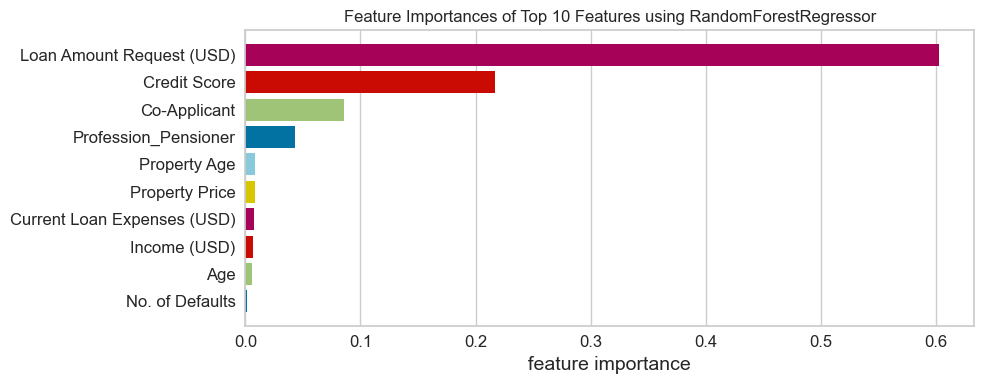

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


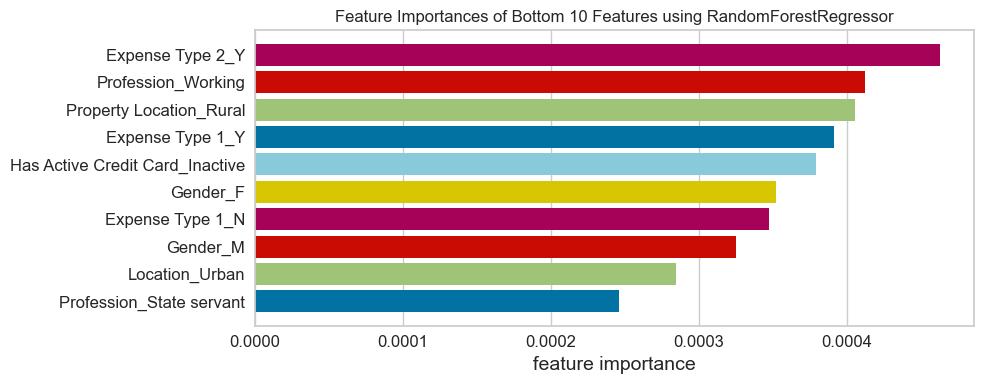

In [244]:
feat_importance(best_rand_for_trn, model_name)

## 5.2 Gradient Boosting Regression

In [245]:
parameters = [
    {
    'n_estimators':[5,50,100,250,500,1000,1500,2000],
    'max_depth':[1,3,5,7,9],
    'loss':['squared_error', 'absolute_error','huber','quantile'],
    'learning_rate':[0.0001,0.001,0.01,0.1,1,10],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features':['auto','sqrt'],
    }
]

In [246]:
grad_boost_dict = {'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42)}

In [247]:
model_name, model = list(grad_boost_dict.keys())[0], list(grad_boost_dict.values())[0]

In [248]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


One or more of the test scores are non-finite: [             nan -7.72339847e+008 -1.14651458e+009 -3.51764825e+199
 -1.64538685e+009              nan -1.30255325e+009             -inf
 -1.66612784e+009 -1.90204812e+009]
invalid value encountered in subtract
overflow encountered in square
One or more of the train scores are non-finite: [             nan -7.40033674e+008 -1.14177268e+009 -3.51764825e+199
 -1.64509725e+009              nan -1.30030975e+009             -inf
 -1.66575374e+009 -1.90089222e+009]
overflow encountered in reduce
overflow encountered in reduce
overflow encountered in reduce
overflow encountered in reduce
overflow encountered in multiply
invalid value encountered in add


**************************************************
nan {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 0.4, 'max_features': 'sqrt', 'max_depth': 7, 'loss': 'quantile', 'learning_rate': 10}
27791.002978243236 {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 0.2, 'max_features': 'auto', 'max_depth': 3, 'loss': 'huber', 'learning_rate': 1}
33860.22114616807 {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 0.30000000000000004, 'max_features': 'auto', 'max_depth': 1, 'loss': 'squared_error', 'learning_rate': 0.001}
5.930976517841057e+99 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 0.1, 'max_features': 'sqrt', 'max_depth': 7, 'loss': 'absolute_error', 'learning_rate': 10}
40563.368271456486 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 0.5, 'max_features': 'sqrt', 'max_depth': 7, 'loss': 'squared_error', 'learning_rate': 0.0001}
nan {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf

In [249]:
best_grad_boost_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

overflow encountered in reduce
overflow encountered in reduce
overflow encountered in reduce
overflow encountered in reduce
overflow encountered in multiply
invalid value encountered in add


X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


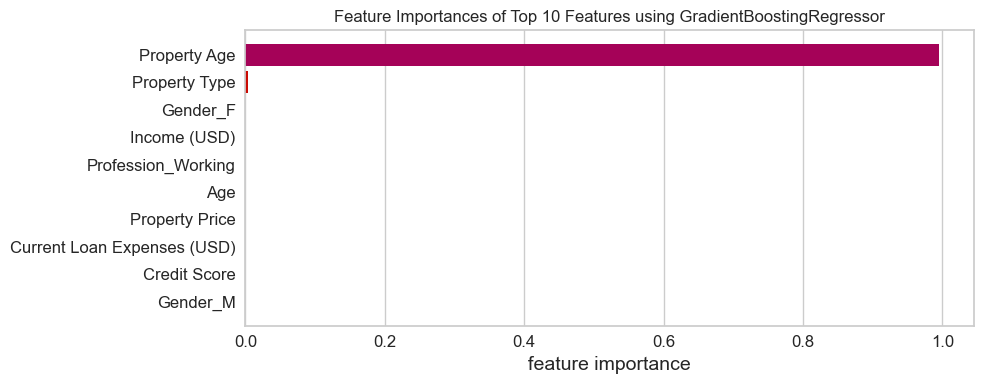

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


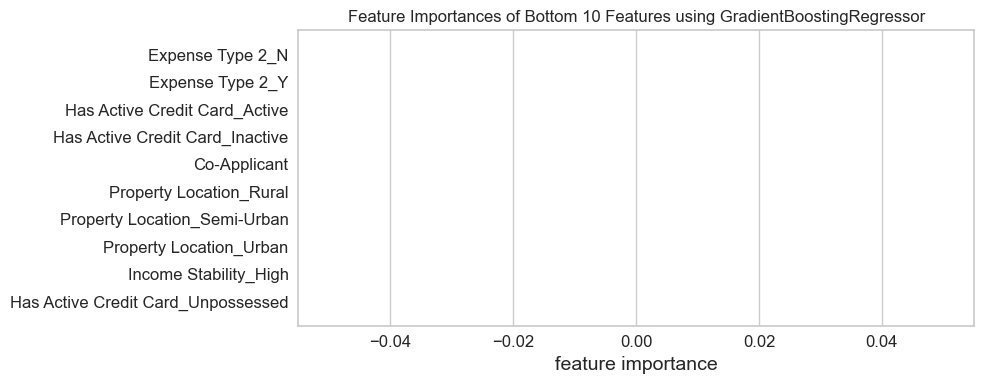

In [250]:
feat_importance(best_grad_boost_trn, model_name)

## 5.3 Extra Trees Regression

In [251]:
n_samples = X_loan_amt_train_prep.shape[0]
n_features = X_loan_amt_train_prep.shape[1]

parameters = [
    {
    'n_estimators': [10, 50, 100, 500, 1000, 2000],
    'max_depth': [None, 2,5,],
    'min_samples_split': [2, 0.5, n_samples//2, ],
    'min_samples_leaf': [1, 0.5, n_samples//2, ],
    'criterion': ['squared_error', 'absolute_error'],
    'max_features': [None, 'sqrt', 'auto', 'log2', 0.3, 0.5, n_features//2],
    'bootstrap':[True, False]
    }
]

In [252]:
extra_trees_dict = {'Extra Trees Regression': ExtraTreesRegressor(random_state=42)}

In [253]:
model_name, model = list(extra_trees_dict.keys())[0], list(extra_trees_dict.values())[0]

In [254]:
folder_check_model(model_name)

In [255]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


**************************************************
41989.015262451845 {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 0.5, 'max_features': 16, 'max_depth': None, 'criterion': 'absolute_error', 'bootstrap': False}
41989.015262451874 {'n_estimators': 100, 'min_samples_split': 8725, 'min_samples_leaf': 0.5, 'max_features': 'log2', 'max_depth': 2, 'criterion': 'absolute_error', 'bootstrap': False}
20917.895422324807 {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': True}
41969.08166538795 {'n_estimators': 50, 'min_samples_split': 0.5, 'min_samples_leaf': 0.5, 'max_features': 'log2', 'max_depth': 2, 'criterion': 'absolute_error', 'bootstrap': True}
30798.726748125402 {'n_estimators': 10, 'min_samples_split': 8725, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': None, 'criterion': 'absolute_error', 'bootstrap': False}
29489.90982922905 {'n_estimators': 2000, '

In [256]:
best_extra_tree_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names


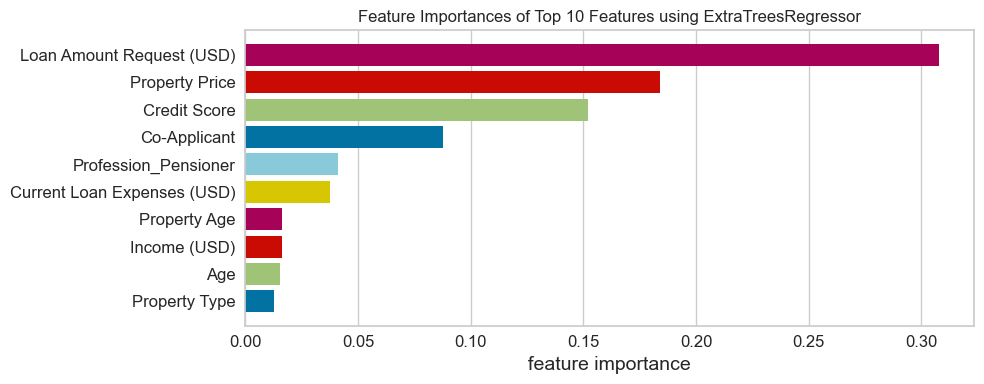

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names


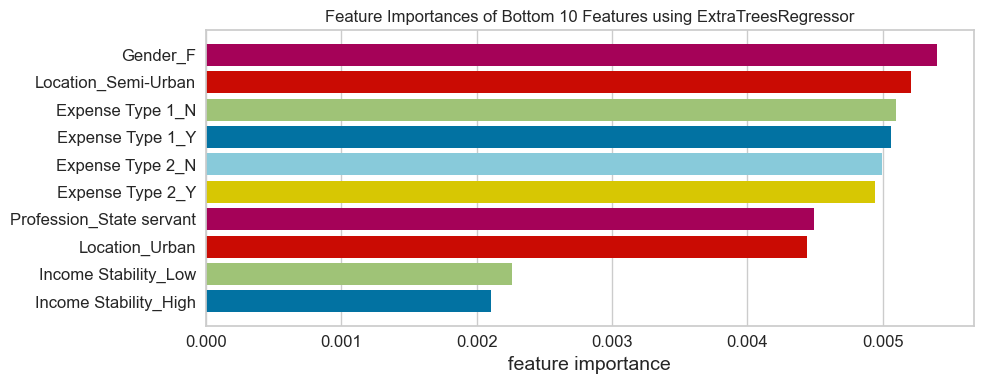

In [257]:
feat_importance(best_extra_tree_trn, model_name)

## 5.4 Bagging Regression

In [258]:
parameters = [
    {
    'base_estimator': [None, LinearRegression(), KNeighborsRegressor()],
    'n_estimators': [20,50,100],
    'max_samples': [0.5,1.0, n_samples//2,],
    'max_features': [0.5,1.0, n_features//2,],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
    }
]

In [259]:
bagging_reg_dict = {'Bagging Regression': BaggingRegressor(random_state=42)}

In [260]:
model_name, model = list(bagging_reg_dict.keys())[0], list(bagging_reg_dict.values())[0]

In [261]:
folder_check_model(model_name)

In [262]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


**************************************************
26653.004837461525 {'n_estimators': 50, 'max_samples': 8725, 'max_features': 0.5, 'bootstrap_features': True, 'bootstrap': False, 'base_estimator': None}
32396.137954501242 {'n_estimators': 20, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True, 'base_estimator': KNeighborsRegressor()}
29877.49678227187 {'n_estimators': 50, 'max_samples': 8725, 'max_features': 16, 'bootstrap_features': True, 'bootstrap': False, 'base_estimator': KNeighborsRegressor()}
26899.80219199704 {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': False, 'base_estimator': LinearRegression()}
28806.13499510351 {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 0.5, 'bootstrap_features': True, 'bootstrap': False, 'base_estimator': LinearRegression()}
26247.31474478566 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 16, 'bootstrap_features': True, 'bootstrap': Tru

In [263]:
best_bagging_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

## 5.5 Final model

We did hyperparameter tuning for the top 4 models, but only the random forest regressor yield an improved score. We will use that model with those parameters.

In [264]:
best_rand_for_trn

RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=1600,
                      random_state=42)

# 6. Test the final model on the test dataset

In [265]:
loan_amt_test_copy.head()

Customer ID             Name Gender  Age  Income (USD) Income Stability  \
0     C-25648   Necole Newbold      M   48      2631.710              Low   
1     C-27924      Ranee Yager      F   58      4445.650              NaN   
2     C-27842     Ivory Toledo      M   25      1586.370              Low   
3      C-7269     Todd Turcios      F   18           NaN              Low   
4     C-47464  Beatriz Lessman      F   36      1591.720              Low   

             Profession Type of Employment    Location  \
0               Working            Drivers  Semi-Urban   
1  Commercial associate           Laborers       Urban   
2  Commercial associate        Sales staff  Semi-Urban   
3  Commercial associate         Core staff  Semi-Urban   
4               Working        Sales staff  Semi-Urban   

   Loan Amount Request (USD)  Current Loan Expenses (USD) Expense Type 1  \
0                  65466.320                      519.540              Y   
1                  88846.600                      392.920              Y   
2                 142786.480                      479.470              N   
3                 119311.640                      433.590              N   
4                  48373.340                      241.160              N   

  Expense Type 2  Dependents  Credit Score  No. of Defaults  \
0              Y       4.000       646.630                0   
1              Y       3.000       701.170                0   
2              Y       2.000       673.920                1   
3              Y       3.000       610.330                0   
4              Y       3.000       728.090                0   

  Has Active Credit Card  Property ID  Property Age  Property Type  \
0            Unpossessed          582      2631.710              3   
1            Unpossessed          319      4445.650              1   
2               Inactive          109      1586.370              4   
3               Inactive          267           NaN              2   
4            Unpossessed          641      1591.720              4   

  Property Location  Co-Applicant  Property Price  Loan Sanction Amount (USD)  
0             Urban             1       72111.030                       0.000  
1        Semi-Urban             1      106418.120                   62192.620  
2             Urban             1      181177.470                   99950.540  
3             Rural             1      213450.090                       0.000  
4             Rural             1       74100.660                       0.000

## 6.1 Data preprocessing for the test set

In [266]:
loan_amt_test_copy_prep = full_pipeline(loan_amt_test_copy)

In [267]:
loan_amt_test_copy_prep

Gender_F  Gender_M  Profession_Commercial associate  \
0         0.000     1.000                            0.000   
1         1.000     0.000                            1.000   
2         0.000     1.000                            1.000   
3         1.000     0.000                            1.000   
4         1.000     0.000                            0.000   
...         ...       ...                              ...   
10495     1.000     0.000                            0.000   
10496     0.000     1.000                            1.000   
10497     1.000     0.000                            0.000   
10498     1.000     0.000                            0.000   
10499     1.000     0.000                            0.000   

       Profession_Pensioner  Profession_State servant  Profession_Working  \
0                     0.000                     0.000               1.000   
1                     0.000                     0.000               0.000   
2                     0.000                     0.000               0.000   
3                     0.000                     0.000               0.000   
4                     0.000                     0.000               1.000   
...                     ...                       ...                 ...   
10495                 0.000                     0.000               1.000   
10496                 0.000                     0.000               0.000   
10497                 0.000                     0.000               1.000   
10498                 0.000                     1.000               0.000   
10499                 0.000                     0.000               1.000   

       Location_Rural  Location_Semi-Urban  Location_Urban  Expense Type 1_N  \
0               0.000                1.000           0.000             0.000   
1               0.000                0.000           1.000             0.000   
2               0.000                1.000           0.000             1.000   
3               0.000                1.000           0.000             1.000   
4               0.000                1.000           0.000             1.000   
...               ...                  ...             ...               ...   
10495           0.000                1.000           0.000             1.000   
10496           0.000                1.000           0.000             0.000   
10497           0.000                1.000           0.000             1.000   
10498           1.000                0.000           0.000             1.000   
10499           0.000                1.000           0.000             1.000   

       Expense Type 1_Y  Expense Type 2_N  Expense Type 2_Y  \
0                 1.000             0.000             1.000   
1                 1.000             0.000             1.000   
2                 0.000             0.000             1.000   
3                 0.000             0.000             1.000   
4                 0.000             0.000             1.000   
...                 ...               ...               ...   
10495             0.000             0.000             1.000   
10496             1.000             0.000             1.000   
10497             0.000             1.000             0.000   
10498             0.000             0.000             1.000   
10499             0.000             0.000             1.000   

       Has Active Credit Card_Active  Has Active Credit Card_Inactive  \
0                              0.000                            0.000   
1                              0.000                            0.000   
2                              0.000                            1.000   
3                              0.000                            1.000   
4                              0.000                            0.000   
...                              ...                              ...   
10495                          0.000                            1.000   
10496                          1.00

In [268]:
X_loan_amt_test_prep, y_loan_amt_test_prep = loan_amt_test_copy_prep.loc[:, loan_amt_test_copy_prep.columns != 'Loan Sanction Amount (USD)'], loan_amt_test_copy_prep['Loan Sanction Amount (USD)']

## 6.2 RMSE on the Test Set

In [269]:
final_predictions = best_rand_for_trn.predict(X_loan_amt_test_prep)

In [270]:
final_mse = mean_squared_error(y_loan_amt_test_prep, final_predictions)

In [271]:
final_rmse = np.sqrt(final_mse)

In [272]:
final_rmse

20807.101202184138

## 6.3 Confidence Intervals

In [273]:
confidence = 0.95

In [274]:
squared_errors = (final_predictions - y_loan_amt_test_prep) ** 2

In [275]:
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

In [276]:
print('The confidence interval at 95% is between {0:.2f} and {1:.2f}'.format(ci[0], ci[1]))

The confidence interval at 95% is between 19944.34 and 21635.49
